In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import ase
import glob
import tqdm
import time
import scipy
import skimage
import numpy as np
import ase.io as aio
import pandas as pd
from scipy.stats import zscore

from toolz.curried import pipe, curry, compose

In [3]:
import plot
import atommks.atomstat as astat
import atommks.helpers as utils

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
plt.style.use('ggplot')
scl = 2
mpl.rcParams['figure.figsize'] = [4.0*scl, 3.0*scl]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 9
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'


def compute_pca(x_data, n_comp=10, vis=True, labels=None, tag=""):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=n_comp)
    scores = pca.fit_transform(x_data)

    if vis:
        ex_var = pca.explained_variance_ratio_ * 100
        plt.bar(np.arange(1, n_comp+1), ex_var)
        plt.ylim([0, 100])
        for ix, item in enumerate(ex_var):
            plt.text(ix+0.5, item+1.0, "{:1.2f}".format(item))
        plt.title("Explained variance plot {}".format(tag))
        plt.grid(b=None)
        plt.show()
        

        if labels is None:
            labels = np.arange(1, len(scores)+1)
            
        plt.scatter(scores[:,0], scores[:,1], c=labels, s=labels)
        plt.xlabel("PC 1")
        plt.ylabel("PC 2")
        plt.grid(b=None)
        plt.title("PC space representation {}".format(tag))
        plt.show()
        
        plt.scatter(scores[:,1], scores[:,2], c=labels, s=labels)
        plt.xlabel("PC 2")
        plt.ylabel("PC 3")
        plt.grid(b=None)
        plt.title("PC space representation {}".format(tag))
        plt.show()
        
    return scores, pca

def plot_corrs_scatter(x, y, xlabel="", ylabel="", title="", xscale="linear", yscale="linear", corr=True):
    plt.plot(x, y, "*--r")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(False)
    if corr:
        title = "{} correlation: {:1.3f}".format(title, 
                                                 np.corrcoef(x, y)[0,1]) 
    plt.title(title)
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.show()
    
def plot_corrs_bar(x, y, title=""):
    corrs = []
    N = x.shape[1]
    for ix in range(N):
        corrs.append(np.fabs(np.corrcoef(x[:,ix], y)[0,1]))
        
    plt.bar(np.arange(N), corrs)
    
    for ix, item in enumerate(corrs):
        plt.text(ix-0.25, 1.0 - 0.01 * ix, "{:1.2f}".format(item))
    
    plt.ylim([0.0, 1.1])
    plt.title(title)
    plt.grid(False)
    plt.show()
    
    
from ase import Atoms 
get_atoms = lambda a: Atoms(["Cu"]*len(a),
                            positions=a.get_positions(),
                            cell=a.get_cell(), 
                            pbc=[1, 1, 1], 
                            tags=a.get_tags())

runs = np.loadtxt("runs.txt").astype(int)

# SAED Analysis

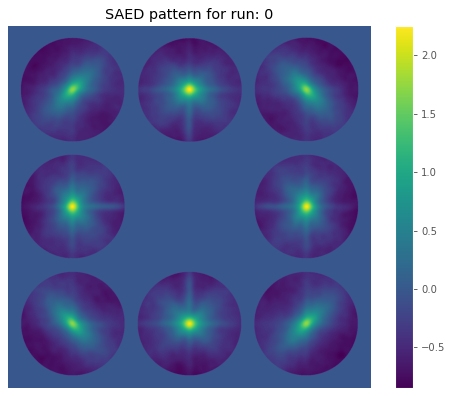

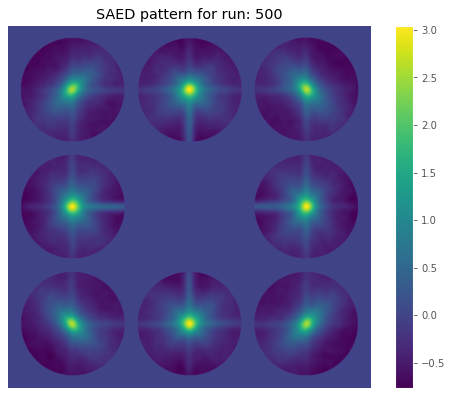

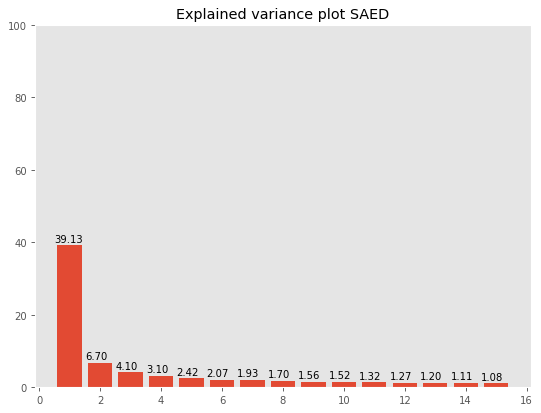

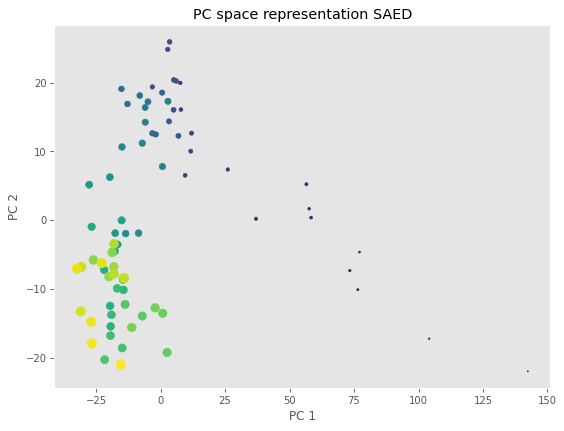

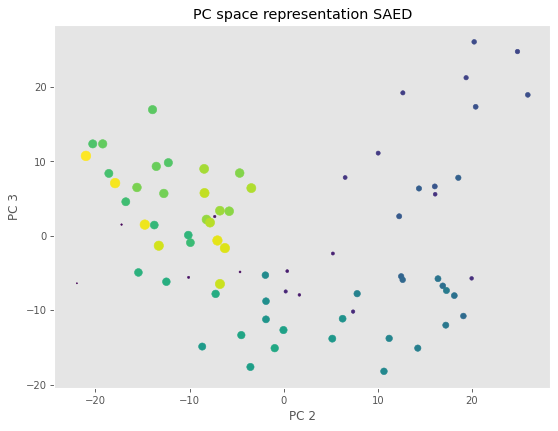

CPU times: user 2min, sys: 9.06 s, total: 2min 9s
Wall time: 16.3 s


In [5]:
%%time
img_saed_h = pipe("data/saed_2048_masked_imgs_hid_blur_10.pkl", 
                  utils.load_file,
                  lambda lst: [np.ravel(x)[None] for x in lst], 
                  curry(np.concatenate)(axis=0))

plot.draw_2d(img_saed_h[0].reshape([1401, 1401]), "SAED pattern for run: {}".format(runs[0]))
plot.draw_2d(img_saed_h[1].reshape([1401, 1401]), "SAED pattern for run: {}".format(runs[1]))

scores_saed_h, pca_saed_h = compute_pca(img_saed_h[1:], n_comp=15, tag="SAED", labels=None)

In [6]:
peaks_1_sum = utils.load_file("peaks_1_max.pkl")
peaks_2_sum = utils.load_file("peaks_2_max.pkl")
saed_peak_1 = utils.load_file("peaks_1_arr.pkl")
saed_peak_2 = utils.load_file("peaks_2_arr.pkl")
peaks_all_sum = utils.load_file("peaks_sum.pkl")

In [ ]:
# plot_corrs_scatter(runs[1:], peaks_1_sum.sum(axis=1)[1:], 
#                    xlabel="No. of irradiation events", 
#                    ylabel="sum of peak 1 intensities")

# plot_corrs_scatter(runs[1:], peaks_2_sum.sum(axis=1)[1:], 
#                    xlabel="No. of irradiation events", 
#                    ylabel="sum of peak 2 intensities")

# plot_corrs_scatter(runs[1:], peaks_all_sum[1:], 
#                    xlabel="No. of irradiation events", 
#                    ylabel="sum of all intensities")

# plot_corrs_scatter(runs[1:], saed_peak_1[1:,0], xlabel="No. of irradiation events", ylabel="peak area")
# plot_corrs_scatter(runs[1:], saed_peak_1[1:,1], xlabel="No. of irradiation events", ylabel="peak perimeter")
# plot_corrs_scatter(runs[1:], saed_peak_1[1:,2], xlabel="No. of irradiation events", ylabel="peak shift")
# plot_corrs_scatter(runs[1:], saed_peak_1[1:,3], xlabel="No. of irradiation events", ylabel="peak eccentricity")

# plot_corrs_scatter(runs[1:], saed_peak_2[1:,0], xlabel="No. of irradiation events", ylabel="peak 2 area")
# plot_corrs_scatter(runs[1:], saed_peak_2[1:,1], xlabel="No. of irradiation events", ylabel="peak 2 perimeter")
# plot_corrs_scatter(runs[1:], saed_peak_2[1:,2], xlabel="No. of irradiation events", ylabel="peak 2 shift")
# plot_corrs_scatter(runs[1:], saed_peak_2[1:,3], xlabel="No. of irradiation events", ylabel="peak 2 eccentricity")

# plot_corrs_scatter(runs[1:], scores_saed_h[:, 0], xlabel="No. of irradiation events", ylabel="SAED PC 1")
# plot_corrs_scatter(runs[1:], scores_saed_h[:, 1], xlabel="No. of irradiation events", ylabel="SAED PC 2")
# plot_corrs_scatter(runs[1:], scores_saed_h[:, 2], xlabel="No. of irradiation events", ylabel="SAED PC 3")
# plot_corrs_scatter(runs[1:], scores_saed_h[:, 3], xlabel="No. of irradiation events", ylabel="SAED PC 4")
# plot_corrs_scatter(runs[1:], scores_saed_h[:, 4], xlabel="No. of irradiation events", ylabel="SAED PC 5")
# plot_corrs_scatter(runs[1:], scores_saed_h[:, 4], xlabel="No. of irradiation events", ylabel="SAED PC 6")

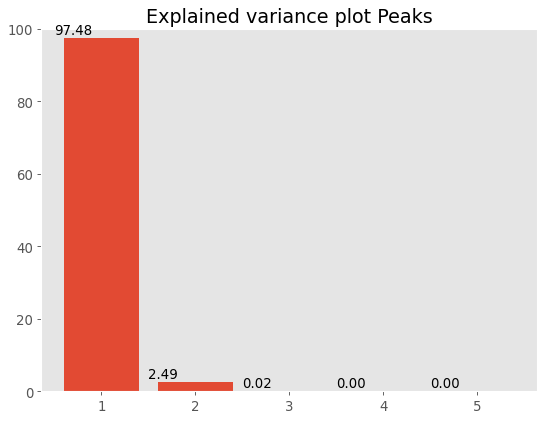

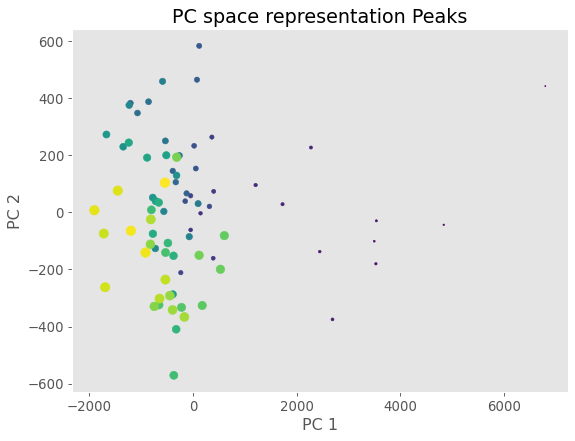

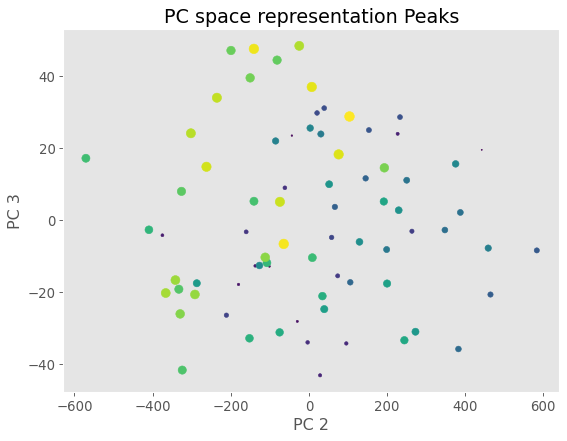

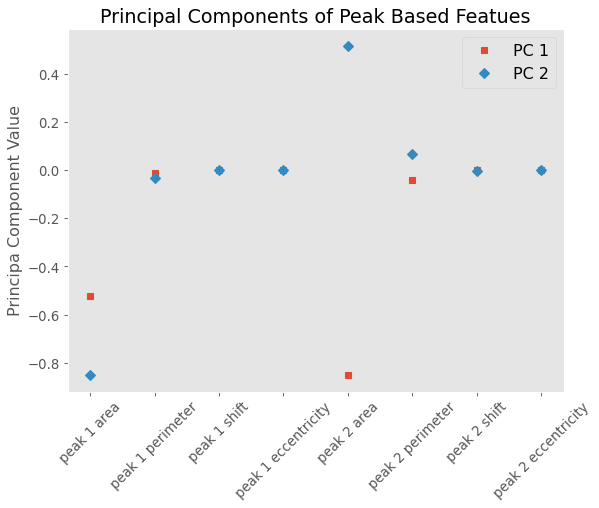

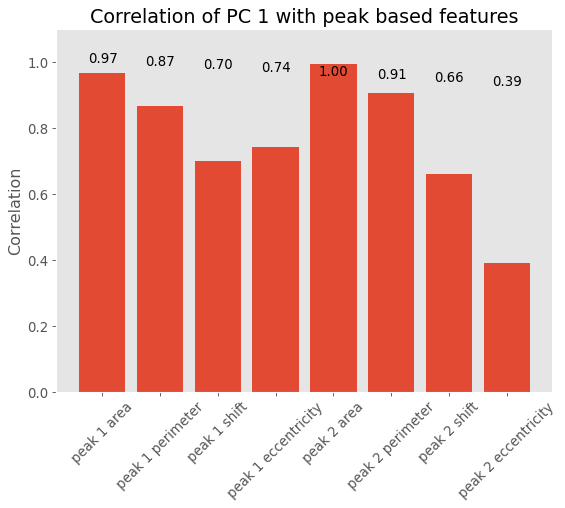

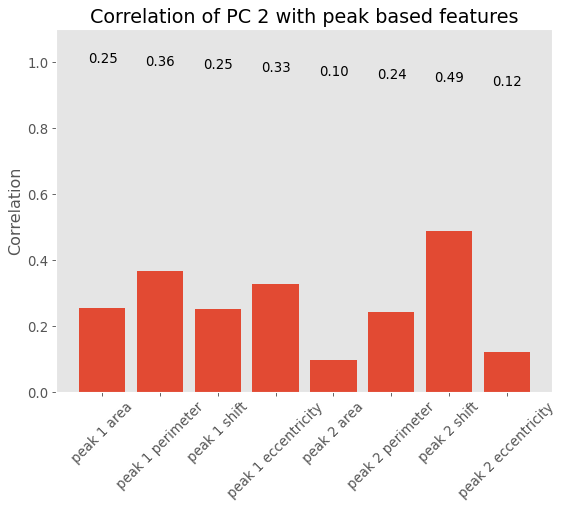

In [45]:
pks_arr = np.concatenate([saed_peak_1[1:,:-1], saed_peak_2[1:,:-1]], axis=1)
scores_pks, pca_pks = compute_pca(pks_arr, n_comp=5, tag="Peaks", labels=None)

lbl_pks = ["peak 1 area", "peak 1 perimeter", "peak 1 shift", "peak 1 eccentricity", 
             "peak 2 area", "peak 2 perimeter", "peak 2 shift", "peak 2 eccentricity",]

pc_vectors = pca_pks.components_.copy()
plt.plot(pc_vectors[0], "s")
plt.plot(pc_vectors[1], "D")
plt.legend(["PC 1", "PC 2"])
# plt.ylabel("Probability")
plt.ylabel("Principa Component Value")
plt.title("Principal Components of Peak Based Featues")
plt.xticks(np.arange(pc_vectors.shape[1]),lbl_pks, rotation=45)
plt.grid(False)
plt.show()

x=pks_arr
y=scores_pks[:,0]
title = ""
corrs = []
N = x.shape[1]
for ix in range(N):
    corrs.append(np.fabs(np.corrcoef(x[:,ix], y)[0,1]))

plt.bar(np.arange(N), corrs)

for ix, item in enumerate(corrs):
    plt.text(ix-0.25, 1.0 - 0.01 * ix, "{:1.2f}".format(item))

plt.ylim([0.0, 1.1])
plt.title("Correlation of PC 1 with peak based features")
plt.grid(False)
plt.xticks(np.arange(pc_vectors.shape[1]),lbl_pks, rotation=45)
plt.ylabel("Correlation")
plt.show()

x=pks_arr
y=scores_pks[:,1]
title = ""
corrs = []
N = x.shape[1]
for ix in range(N):
    corrs.append(np.fabs(np.corrcoef(x[:,ix], y)[0,1]))

plt.bar(np.arange(N), corrs)

for ix, item in enumerate(corrs):
    plt.text(ix-0.25, 1.0 - 0.01 * ix, "{:1.2f}".format(item))

plt.ylabel("Correlation")
plt.ylim([0.0, 1.1])
plt.title("Correlation of PC 2 with peak based features")
plt.grid(False)
plt.xticks(np.arange(pc_vectors.shape[1]),lbl_pks, rotation=45)
plt.show()

In [69]:
n_comp = np.min(img_saed_h[1:].shape)
scores_saed, pca_saed = compute_pca(img_saed_h[1:], n_comp=n_comp, vis=False)
lbls = ["SAED PC {}".format(ix+1) for ix in range(n_comp)]
vals = pca_saed.explained_variance_ratio_[None]
df = pd.DataFrame(vals, columns=lbls)
df.to_csv("csv/SAED_MIF_pca_exVar.csv")


pks_arr = np.concatenate([saed_peak_1[1:,:-1], saed_peak_2[1:,:-1]], axis=1)
n_comp = np.min(pks_arr.shape)
scores_pks, pca_pks = compute_pca(pks_arr, n_comp=n_comp, vis=False)
lbls = ["Peaks PC {}".format(ix+1) for ix in range(n_comp)]
vals = pca_pks.explained_variance_ratio_[None]
df = pd.DataFrame(vals, columns=lbls)
df.to_csv("csv/SAED_HIF_pca_exVar.csv")
df.head(3)

,Peaks PC 1,Peaks PC 2,Peaks PC 3,Peaks PC 4,Peaks PC 5,Peaks PC 6,Peaks PC 7,Peaks PC 8
0,0.97484,0.024895,0.000246,0.000018,4.537926e-07,7.878878e-08,1.696195e-09,1.548655e-11


In [70]:
y_lbl_pca = ["SAED PC {}".format(i+1) for i in range(scores_saed.shape[1])]
y_lbl_pks = ["peak 1 intensity", "peak 1 area", "peak 1 perimeter", "peak 1 shift", "peak 1 eccentricity", 
             "peak 2 intensity", "peak 2 area", "peak 2 perimeter", "peak 2 shift", "peak 2 eccentricity",]
y_lbl_pks += ["peaks PC {}".format(i+1) for i in range(scores_pks.shape[1])]

df_pks = pd.DataFrame(np.concatenate([peaks_1_sum.sum(axis=1)[1:,None], 
                                      saed_peak_1[1:,:-1], 
                                      peaks_2_sum.sum(axis=1)[1:,None], 
                                      saed_peak_2[1:,:-1], 
                                      scores_pks], 
                                     axis=1), 
                      columns=y_lbl_pks)

df_pca = pd.DataFrame(scores_saed, columns=y_lbl_pca)
df_saed = pd.concat([df_pks, df_pca], axis=1)
pd.DataFrame(df_saed.corr()).to_csv("csv/SAED_features_correlations.csv")

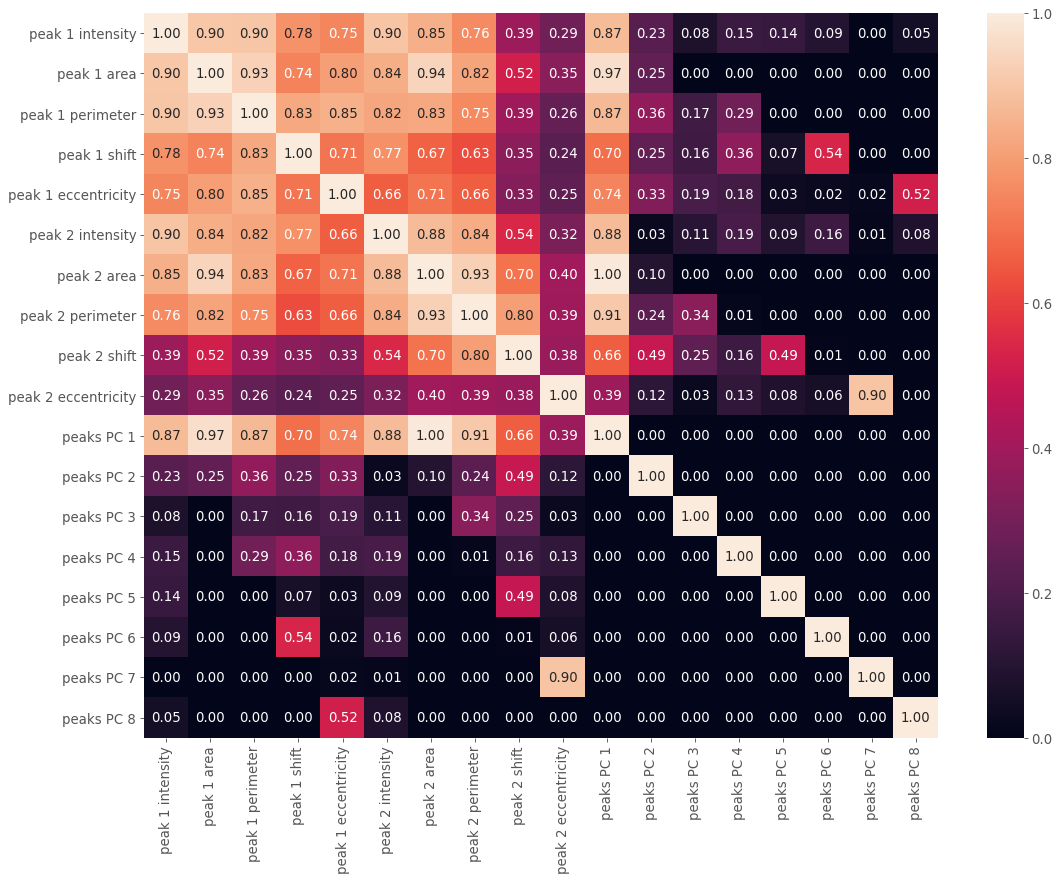

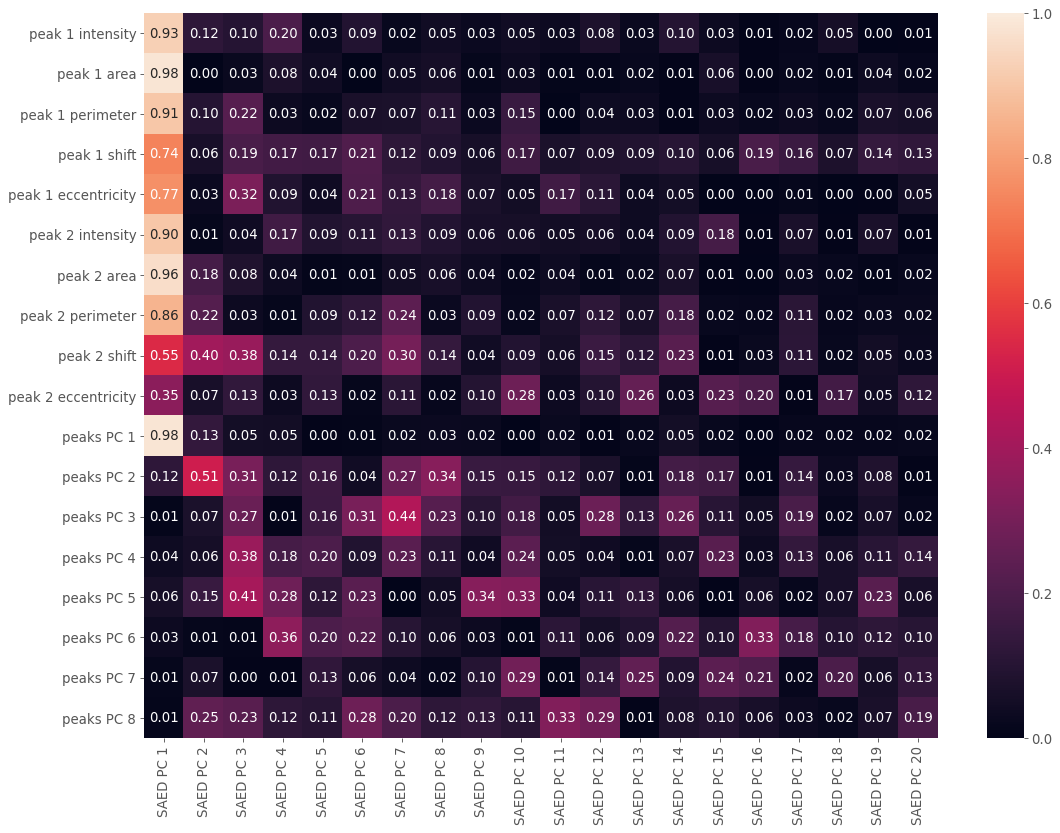

In [72]:
plt.figure(figsize=(16,12))
plt.rcParams.update({'font.size': 12})
g = sns.heatmap(df_pks.corr().abs(), annot=True, fmt=".2f", vmin=0, vmax=1.0)
g.collections[0].colorbar.ax.set_ylim(0.0, 1.0)
plt.show()

corr_dct = {}
for lbl in y_lbl_pca[:20]:
      corr_dct[lbl] = df_pks.corrwith(df_pca[lbl])
        
df_corr = pd.DataFrame(corr_dct, index=y_lbl_pks).abs()

plt.figure(figsize=(16,12))
plt.rcParams.update({'font.size': 12})
g = sns.heatmap(df_corr, annot=True, fmt=".2f", vmin=0, vmax=1.0)
g.collections[0].colorbar.ax.set_ylim(0.0,1.0)
plt.show()

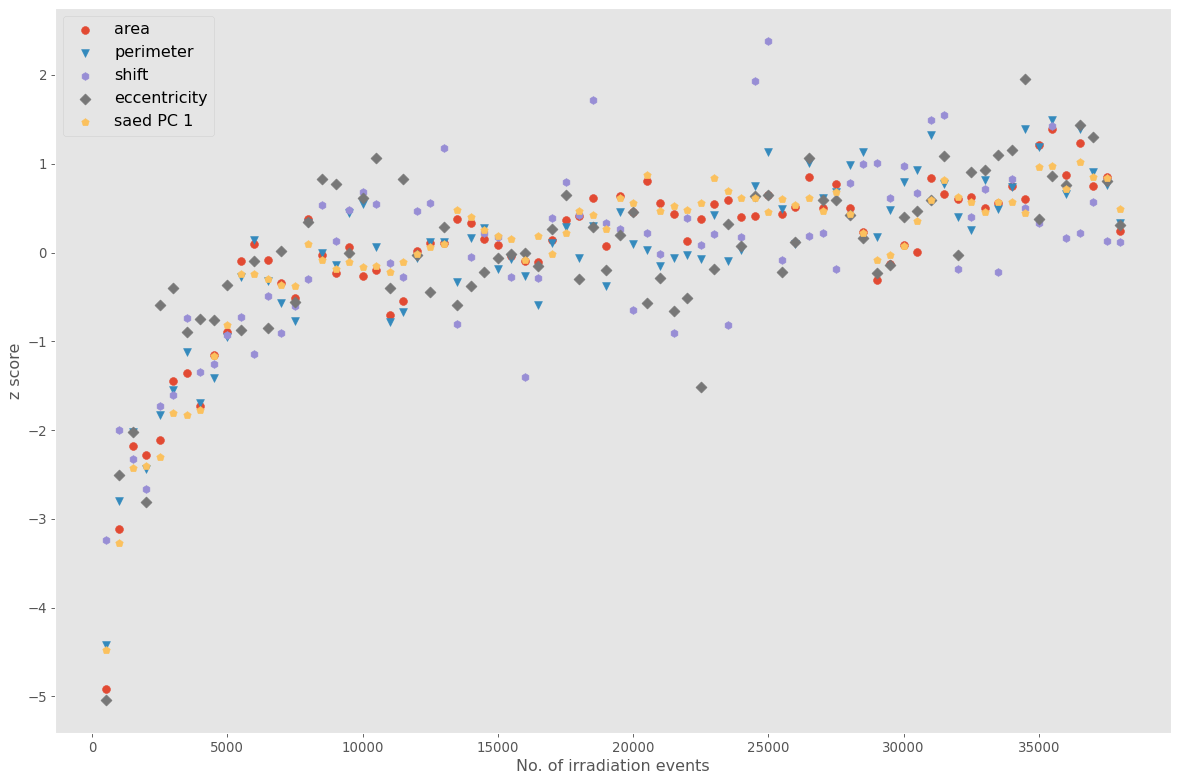

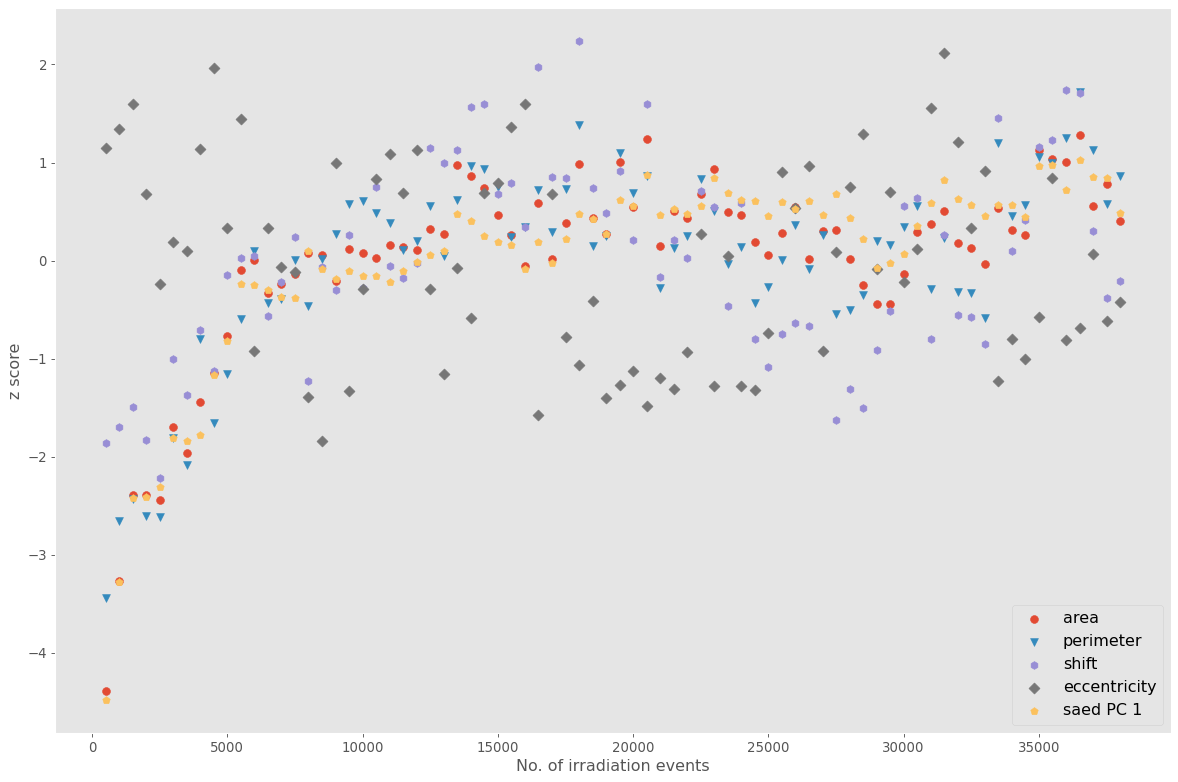

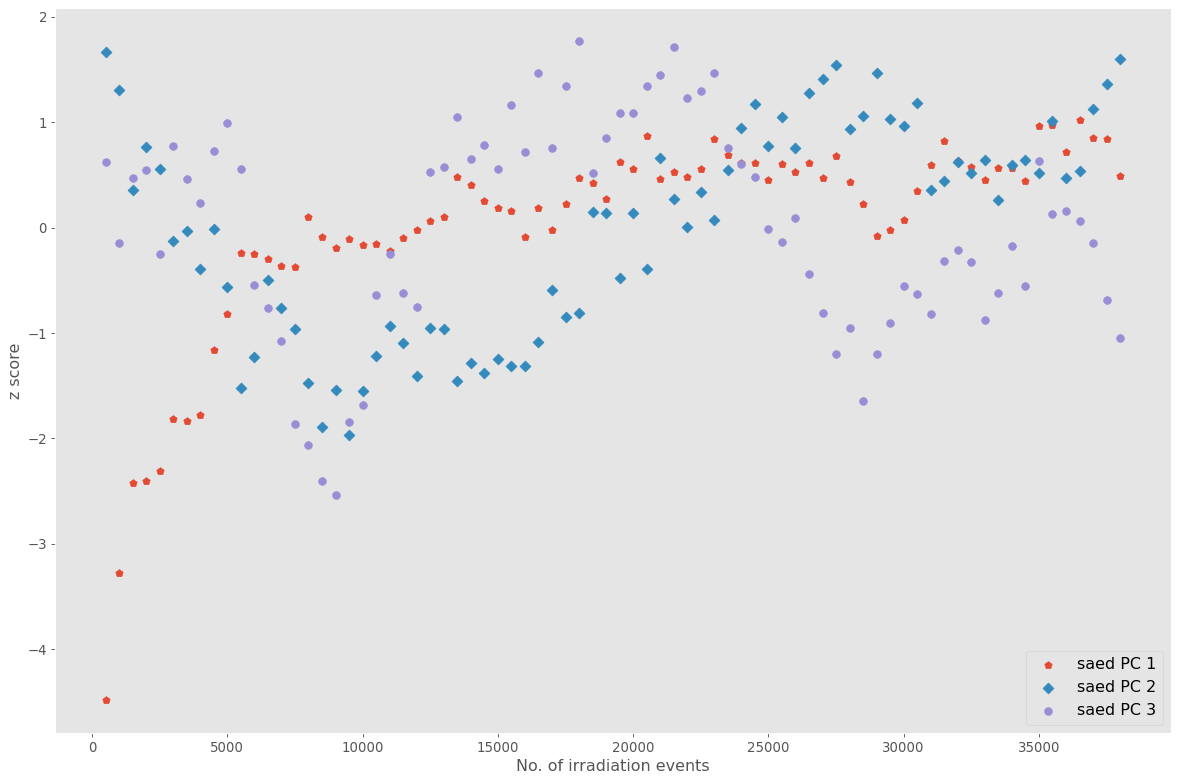

In [73]:
plt.figure(figsize=(18,12))
plt.scatter(runs[1:], zscore(df_pks["peak 1 area"]), s=50, marker="o")
plt.scatter(runs[1:], zscore(df_pks["peak 1 perimeter"]), s=50, marker="v")
plt.scatter(runs[1:], -1*zscore(df_pks["peak 1 shift"]), s=50, marker="h")
plt.scatter(runs[1:], -1*zscore(df_pks["peak 1 eccentricity"]), s=50, marker="D")
plt.scatter(runs[1:], -1*zscore(df_pca["SAED PC 1"]), s=50, marker="p")
plt.legend(["area", "perimeter", "shift","eccentricity", "saed PC 1"])
plt.xlabel("No. of irradiation events")
plt.ylabel("z score")
plt.grid(False)
plt.show()

plt.figure(figsize=(18,12))
plt.scatter(runs[1:], zscore(df_pks["peak 2 area"]), s=50, marker="o")
plt.scatter(runs[1:], zscore(df_pks["peak 2 perimeter"]), s=50, marker="v")
plt.scatter(runs[1:], -1*zscore(df_pks["peak 2 shift"]), s=50, marker="h")
plt.scatter(runs[1:], -1*zscore(df_pks["peak 2 eccentricity"]), s=50, marker="D")
plt.scatter(runs[1:], -1*zscore(df_pca["SAED PC 1"]), s=50, marker="p")
plt.legend(["area", "perimeter", "shift","eccentricity", "saed PC 1"])
plt.xlabel("No. of irradiation events")
plt.ylabel("z score")
plt.title("")
plt.grid(False)
plt.show()


plt.figure(figsize=(18,12))
plt.scatter(runs[1:], -1*zscore(df_pca["SAED PC 1"]), s=50, marker="p")
plt.scatter(runs[1:], -1*zscore(df_pca["SAED PC 2"]), s=50, marker="D")
plt.scatter(runs[1:], -1*zscore(df_pca["SAED PC 3"]), s=50, marker="o")
plt.legend(["saed PC 1", "saed PC 2", "saed PC 3"])
plt.xlabel("No. of irradiation events")
plt.ylabel("z score")
plt.title("")
plt.grid(False)
plt.show()

# Structure Analysis

  0%|          | 0/76 [00:00<?, ?it/s]

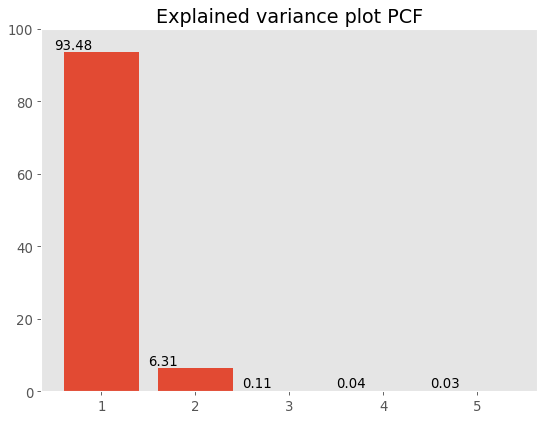

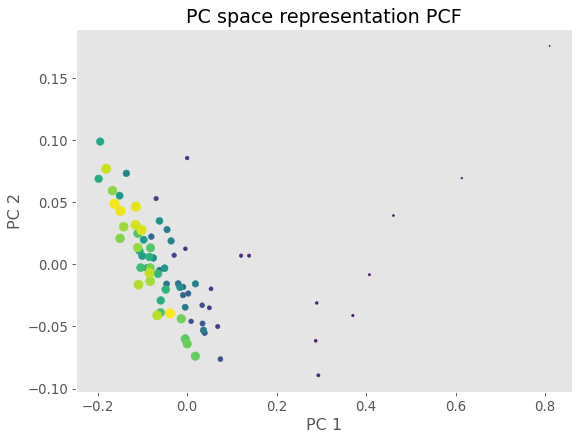

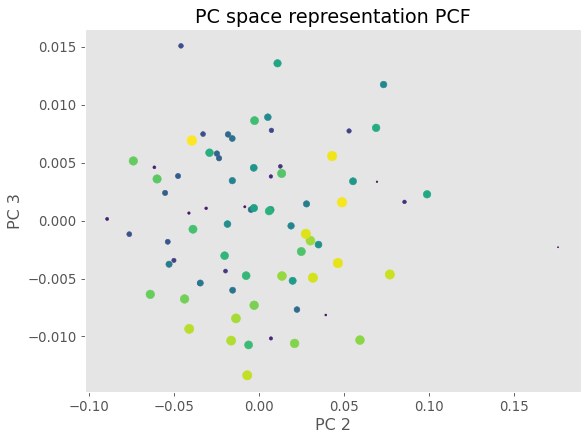

In [87]:
pcf_list = []
for run in tqdm.notebook.tqdm(runs[1:]):
    f_pcf = "data/porespy_3/dump.arc.{}_pores.pkl".format(run)
    pcf_sig = utils.load_file(f_pcf)['tpt']
    pcf_list.append(pcf_sig[None])

n_comp = 5
pcf_arr = np.concatenate(pcf_list, axis=0)
scores_pcf, pca_pcf = compute_pca(pcf_arr, n_comp=n_comp, tag="PCF", labels=None)

df_pcf = pd.DataFrame(pcf_arr, columns=np.arange(pcf_arr.shape[1])*2+0.5) 
df_pcf.to_csv("csv/structure_pcf_raw.csv")

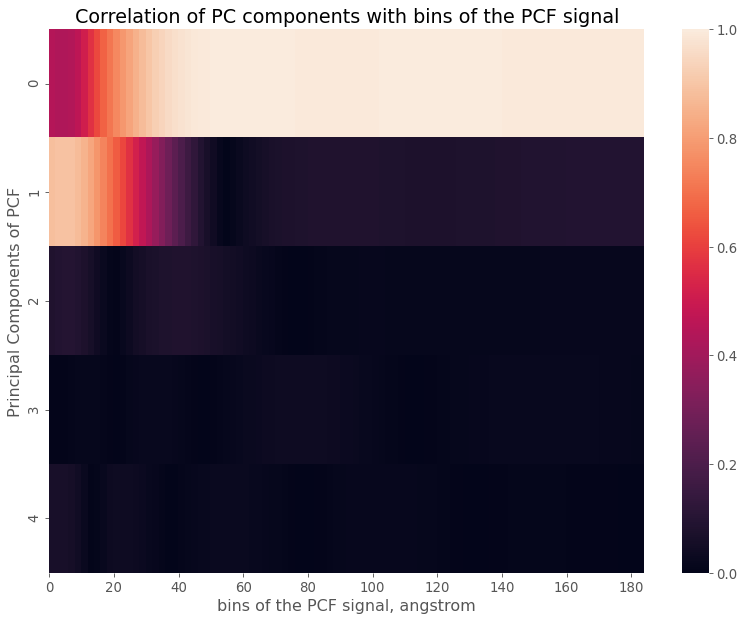

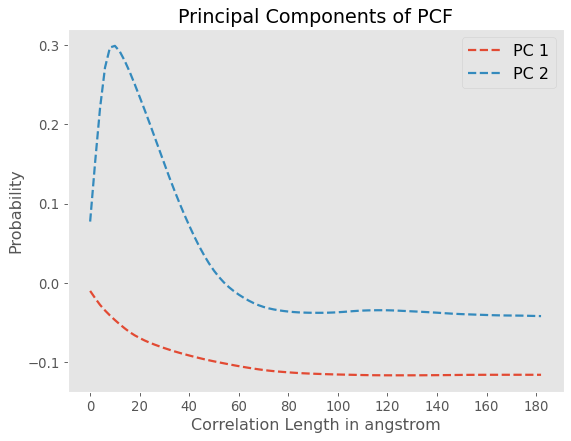

In [90]:
x = pcf_arr.copy()
y = scores_pcf.copy()
n_bins = pcf_arr.shape[1]
corr_sig = np.zeros((n_bins, n_comp))
for i0 in range(n_bins):
    for i1 in range(n_comp):
        corr_sig[i0, i1] = np.fabs(np.corrcoef(x[:,i0], y[:,i1])[0,1])

plt.figure(figsize=(12,9))
plt.rcParams.update({'font.size': 12})
g = sns.heatmap(corr_sig.T, annot=False, vmin=0, vmax=1.0)
g.collections[0].colorbar.ax.set_ylim(0.0,1.0)
plt.ylabel("Principal Components of PCF")
plt.xlabel("bins of the PCF signal, angstrom")
plt.xticks(np.arange(n_bins)[::10], np.arange(n_bins)[::10]*2)
plt.title("Correlation of PC components with bins of the PCF signal")
plt.show()

pc_vectors = pca_pcf.components_.copy()
plt.plot(pc_vectors[0], "--")
plt.plot(pc_vectors[1], "--")
plt.legend(["PC 1", "PC 2"])
plt.ylabel("Probability")
plt.xlabel("Correlation Length in angstrom")
plt.title("Principal Components of PCF")
plt.xticks(np.arange(n_bins)[::10], np.arange(n_bins)[::10]*2)
plt.grid(False)
plt.show()

df_pcf_pca = pd.DataFrame( pca_pcf.components_.copy(), columns=np.arange(pcf_arr.shape[1])*2+0.5) 
df_pcf_pca.to_csv("csv/structure_pcf_pca.csv")

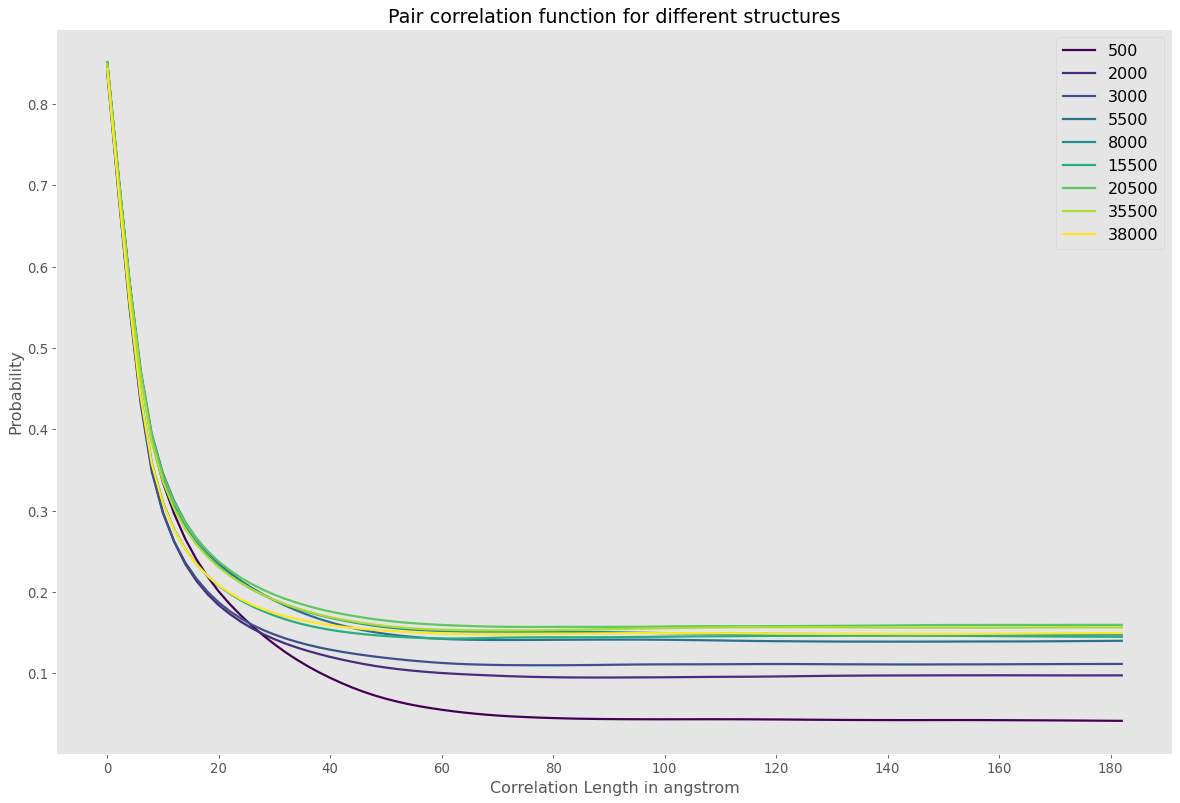

In [91]:
plt.figure(figsize=(18,12))
leg = []
p_list = [0, 3, 5, 10, 15, 30, 40, 70, 75]
colors = plt.cm.viridis(np.linspace(0,1,len(p_list)))
for cx, ix in enumerate(p_list):
    plt.plot(pcf_arr[ix], color = colors[cx])
    leg.append(runs[ix+1])
plt.title("Pair correlation function for different structures")
plt.legend(leg)
plt.ylabel("Probability")
plt.xlabel("Correlation Length in angstrom")
plt.xticks(np.arange(pcf_arr.shape[1])[::10], (np.arange(pcf_arr.shape[1])*2)[::10])
plt.grid(False)
plt.show()

  0%|          | 0/76 [00:00<?, ?it/s]

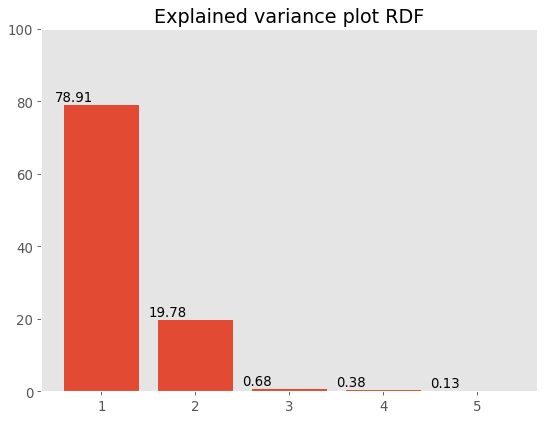

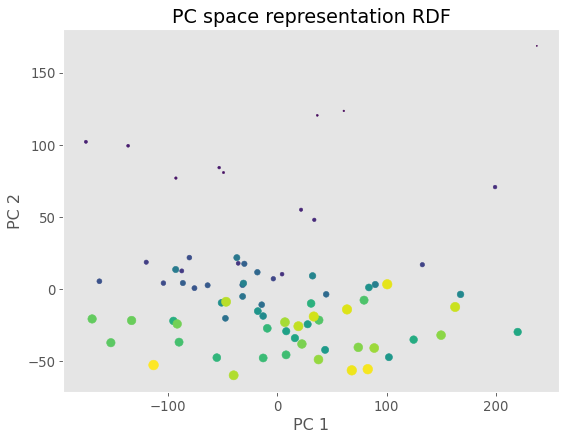

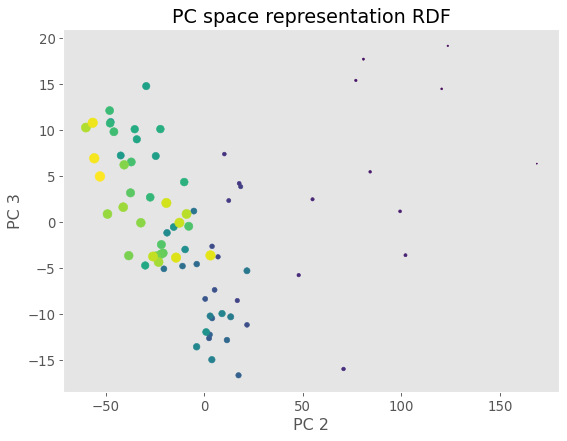

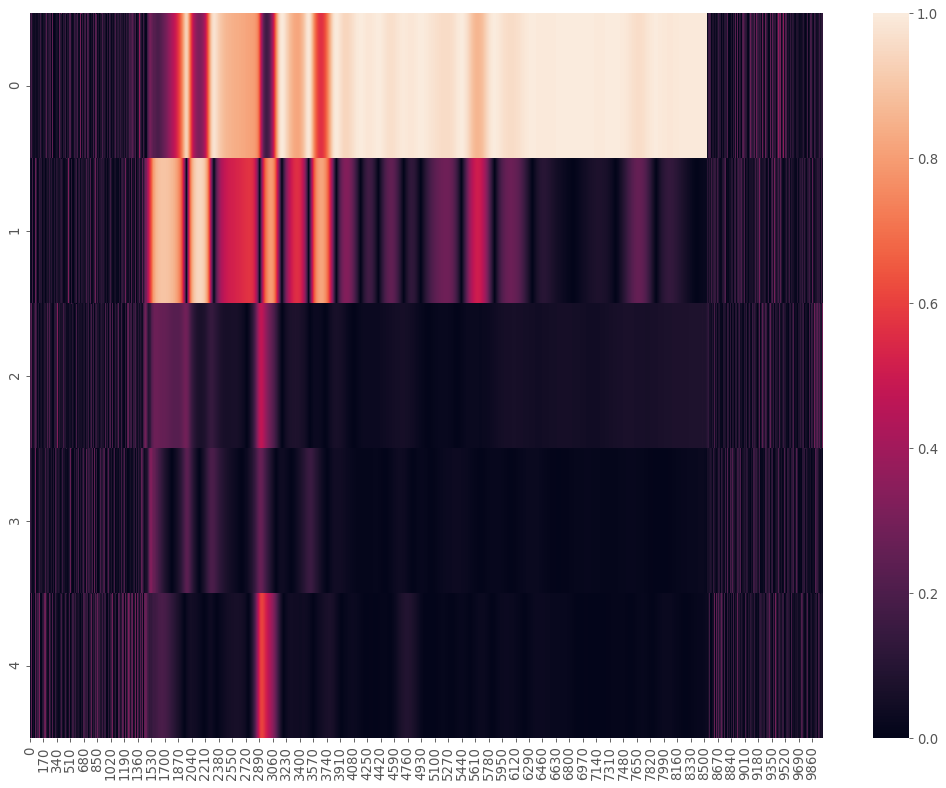

In [92]:
rdf_list_def = []
for run in tqdm.notebook.tqdm(runs[1:]):
    f_stat_def = "data/rdfs_def/dump.arc.{}_stat.pkl".format(run)
    stat_def = utils.load_file(f_stat_def)
    rdf_list_def.append(stat_def[None])
    
rdfs_def = np.concatenate(rdf_list_def, axis=0)

n_features = rdfs_def.shape[1]
n_comp = 5

scores_rdf_def, pca_rdf_def = compute_pca(rdfs_def, n_comp=n_comp, tag="RDF", labels=None)

corr_pca_def = np.zeros((n_features, n_comp))
for i0 in range(n_features):
    for i1 in range(n_comp):
        corr_pca_def[i0, i1] = np.fabs(np.corrcoef(rdfs_def[:,i0], scores_rdf_def[:,i1])[0,1])

plt.figure(figsize=(16,12))
plt.rcParams.update({'font.size': 12})
g = sns.heatmap(corr_pca_def.T, annot=False, vmin=0, vmax=1.0)
g.collections[0].colorbar.ax.set_ylim(0.0,1.0)
plt.show()

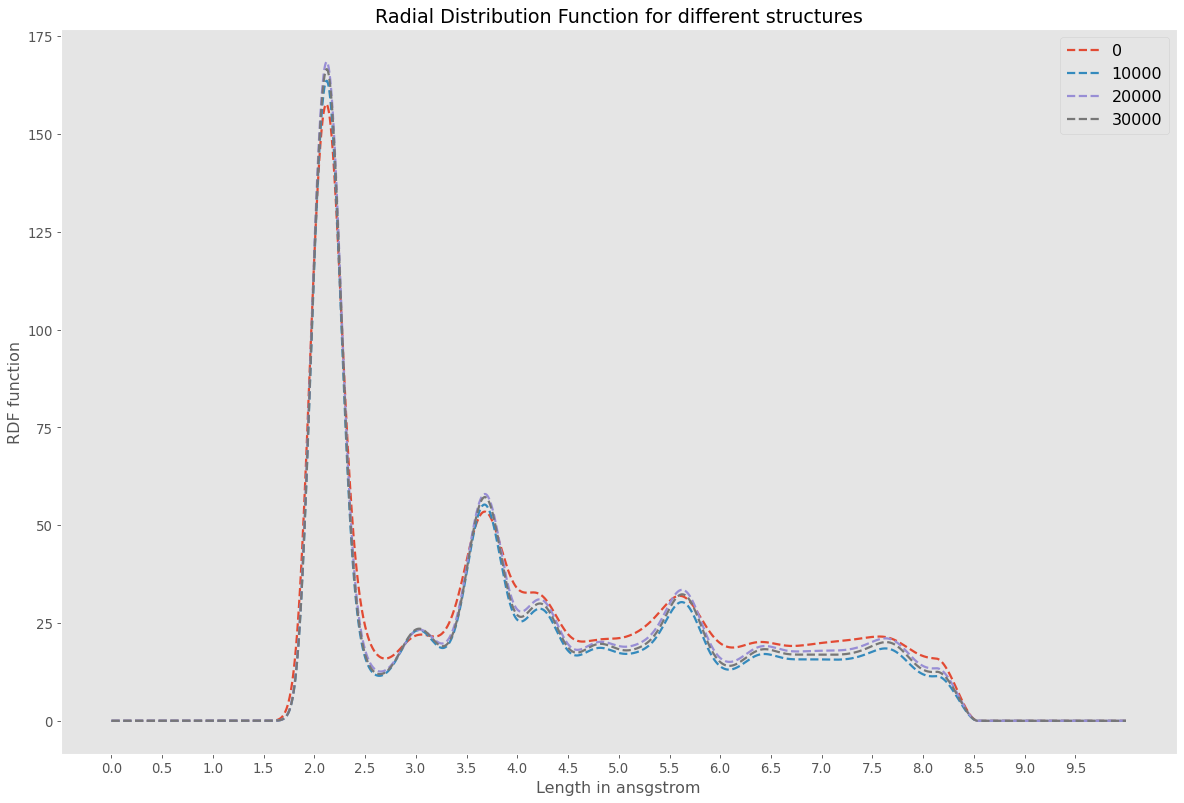

In [14]:
x = rdfs_def.copy()
plt.figure(figsize=(18,12))
for ix in range(0, 76, 20):
    plt.plot(x[ix], "--")
plt.title("Radial Distribution Function for different structures")
plt.legend([runs[ix] for ix in range(0, 76, 20)])
plt.ylabel("RDF function")
plt.xlabel("Length in ansgstrom")
plt.xticks(np.arange(x.shape[1])[::500], (np.arange(x.shape[1]))[::500]*0.001)
plt.grid(False)
plt.show()

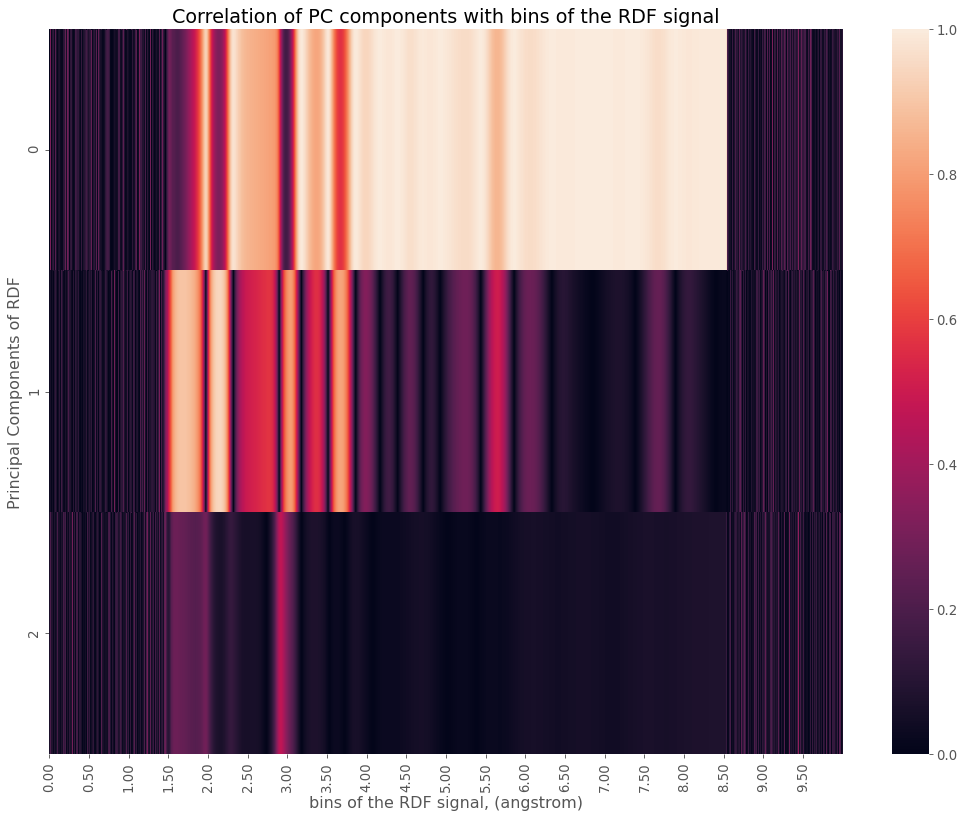

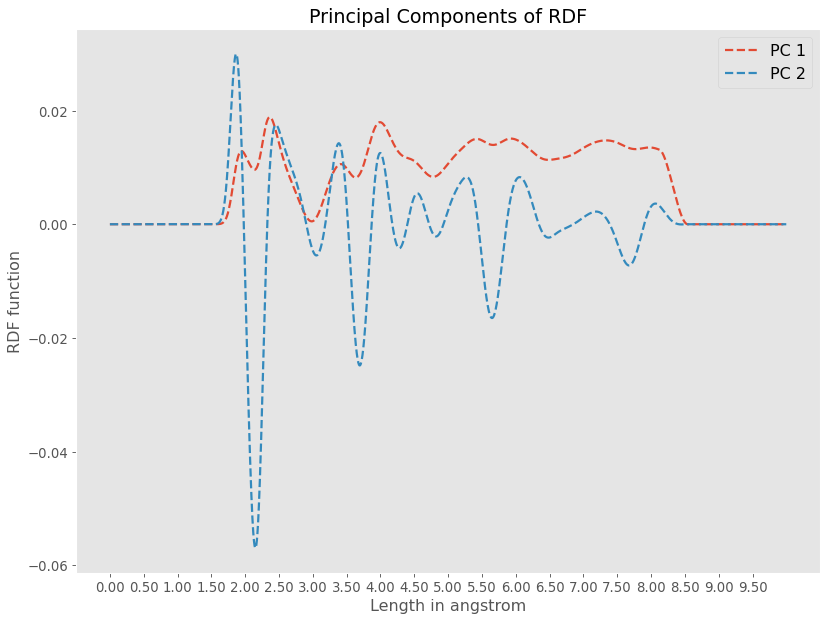

In [15]:
rdf_range = 10000
corr_pca_def = np.zeros((rdf_range, 3))
for i0 in range(rdf_range):
    for i1 in range(3):
        corr_pca_def[i0, i1] = np.fabs(np.corrcoef(rdfs_def[:,i0], scores_rdf_def[:,i1])[0,1])

plt.figure(figsize=(16,12))
plt.rcParams.update({'font.size': 12})
g = sns.heatmap(corr_pca_def.T, annot=False, vmin=0, vmax=1.0)
g.collections[0].colorbar.ax.set_ylim(0.0,1.0)
plt.ylabel("Principal Components of RDF")
plt.xlabel("bins of the RDF signal, (angstrom)")
plt.title("Correlation of PC components with bins of the RDF signal")
plt.xticks(np.arange(rdf_range)[::500], ["{:1.2f}".format(x) for x in np.linspace(0, rdf_range/1000, rdf_range)[::500]])
plt.show()

plt.figure(figsize=(12,9))
pc_vectors = pca_rdf_def.components_.copy()
plt.plot(pc_vectors[0], "--")
plt.plot(pc_vectors[1], "--")
plt.legend(["PC 1", "PC 2"])
plt.ylabel("RDF function")
plt.xlabel("Length in angstrom")
plt.title("Principal Components of RDF")
plt.xticks(np.arange(rdf_range)[::500], ["{:1.2f}".format(x) for x in np.linspace(0, rdf_range/1000, rdf_range)[::500]])
plt.grid(False)
plt.show()

In [22]:
# props_vol = {}
# for run in tqdm.notebook.tqdm(runs[1:]):
#     dct = utils.load_file("data/props/dump.arc.{}_props.pkl".format(run))
#     props_vol[run] = {}
#     for r_atom in np.arange(1., 7.01, 1.):        
#         props_vol[run][r_atom] = dct[r_atom]['area']
        
# for r_atom in np.arange(1., 7.01, 1.): 
#     v_rms = []
# #     v_avg = []
# #     v_tot = []
#     n_cls = []
#     for run in runs[1:]:
#         vols = np.array(props_vol[run][r_atom])
#         n_cls.append(len(vols))
# #         v_tot.append(np.sum(vols))
# #         v_avg.append(np.mean(vols))
#         v_rms.append(np.sqrt(np.mean(vols**2)))
    
#     print(r_atom)
#     print("no. of clusters: {:1.3f}".format(np.corrcoef(n_cls, df_pca["PC 1"])[0,1]))
#     print("rms volume: {:1.3f}".format(np.corrcoef(v_rms, df_pca["PC 1"])[0,1]))

In [16]:
# # Load arc_dpa data
# with open("../new-data/200629CK_Cu_ACC_Analysis/kr_arc_dpa.txt", "r") as f:
#     lines = f.readlines()
# n_atoms_dpa = []
# for run in runs[1:]:
#     n_atoms_dpa.append(int(lines[run].split()[-2]))

r_atom = 3.0
vols = {}
n_atoms_irr = []
for run in tqdm.notebook.tqdm(runs[1:]):
    
    atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(run), 
         lambda f: utils.load_file(f), 
         lambda a: get_atoms(a))
    idx = np.where(atoms.get_tags() != 1)[0]
    
    n_atoms_irr.append(len(idx))
    vols[run] = utils.load_file("data/props/dump.arc.{}_props.pkl".format(run))[r_atom]['area']

  0%|          | 0/76 [00:00<?, ?it/s]

In [21]:
v_tot = [np.sum(vols[run]) for run in runs[1:]]
v_avg = [np.mean(vols[run]) for run in runs[1:]]
v_rms = [np.sqrt(np.mean(np.array(vols[run])**2)) for run in runs[1:]]

vals = []
for ix in range(1, 77):
    with open("data/irr-defect/dump.arc.DXA-results.{}.txt".format(ix), "r") as f:
        lines = f.readlines()
    keys = [l[1:-1] for l in lines[0].split()[1:]]
    vals.append(np.array([np.float(l) for l in lines[1].split()])[None])
vals = np.concatenate(vals, axis=0)

df_x_def = pd.DataFrame(vals, columns=keys)
df_x_def.head(3)

,Timestep,DislocationAnalysis.cell_volume,DislocationAnalysis.counts.BCC,DislocationAnalysis.counts.CubicDiamond,DislocationAnalysis.counts.FCC,DislocationAnalysis.counts.HCP,DislocationAnalysis.counts.HexagonalDiamond,DislocationAnalysis.counts.OTHER,DislocationAnalysis.length.1/2<110>,DislocationAnalysis.length.1/3<100>,...,DislocationAnalysis.length.1/6<110>,DislocationAnalysis.length.1/6<112>,DislocationAnalysis.length.other,DislocationAnalysis.total_line_length,PolyhedralTemplateMatching.counts.BCC,PolyhedralTemplateMatching.counts.FCC,PolyhedralTemplateMatching.counts.HCP,PolyhedralTemplateMatching.counts.ICO,PolyhedralTemplateMatching.counts.OTHER,PolyhedralTemplateMatching.counts.SC
0,20000.0,47812740.0,0.0,0.0,3898161.0,16670.0,0.0,85169.0,618.218567,1323.302979,...,4634.693359,23232.117188,791.553894,31008.867188,364.0,3912410.0,20919.0,6.0,66300.0,1.0
1,40000.0,47812740.0,0.0,0.0,3846586.0,29333.0,0.0,124081.0,1013.582092,1876.629761,...,7696.310547,34864.773438,1089.544434,47331.039062,571.0,3867494.0,36314.0,2.0,95616.0,3.0
2,60000.0,47812740.0,0.0,0.0,3802563.0,37601.0,0.0,159836.0,1435.168945,2396.071045,...,10655.726562,44546.601562,1438.534180,61574.656250,740.0,3828921.0,46106.0,1.0,124230.0,2.0


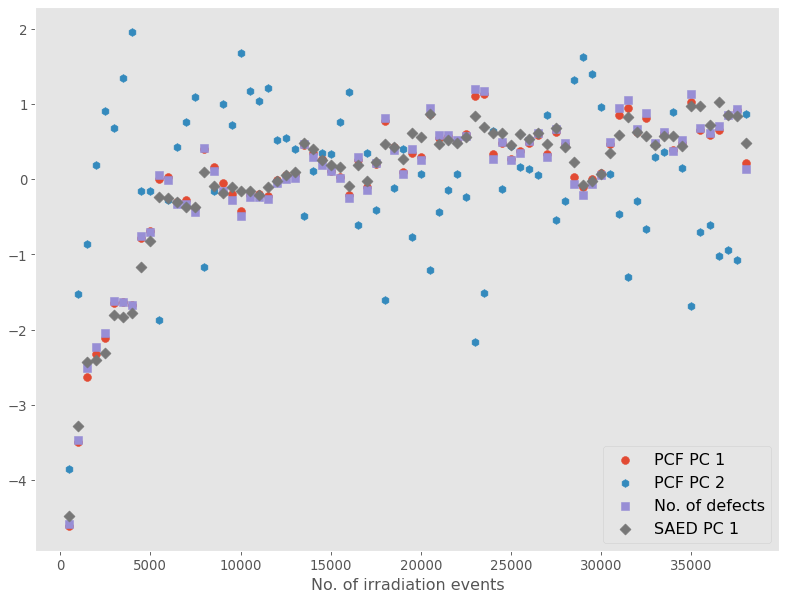

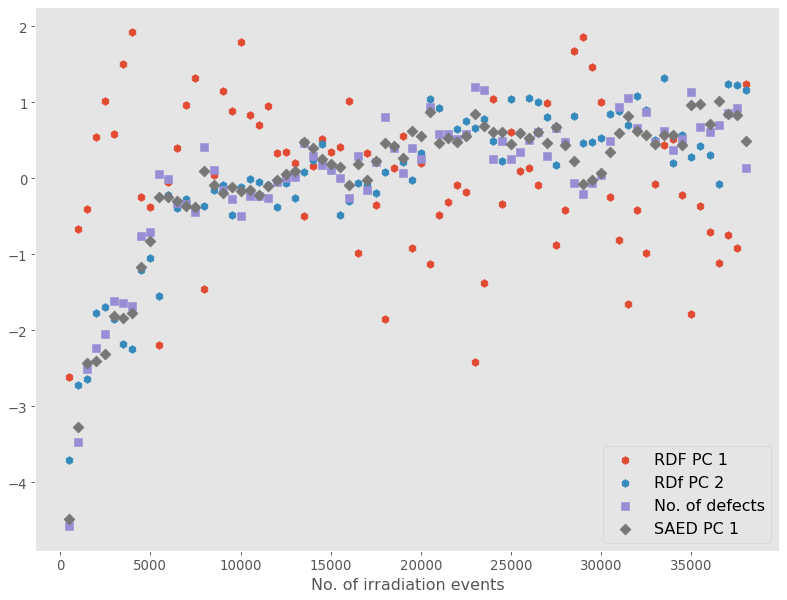

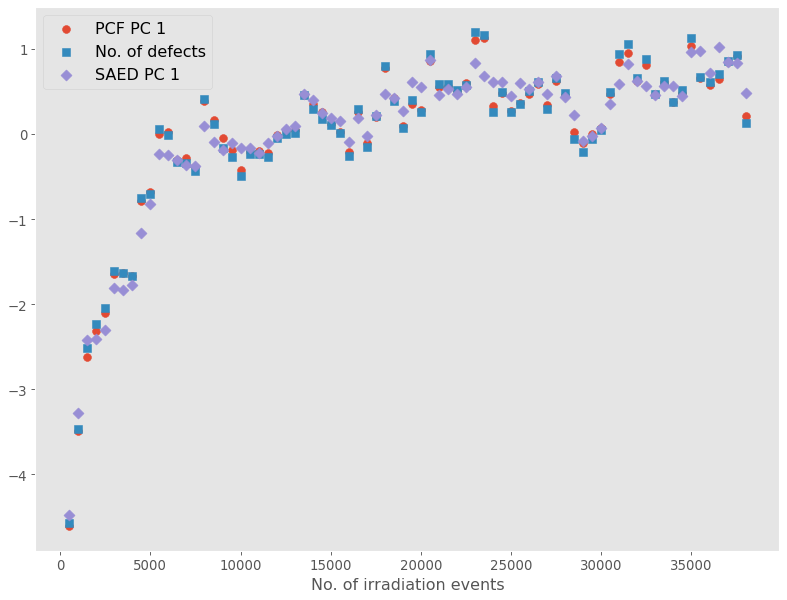

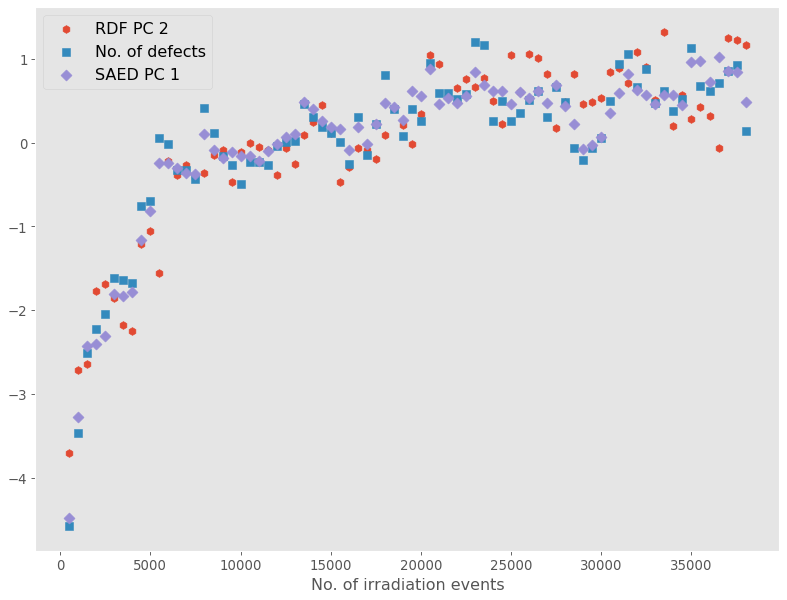

In [19]:
plt.figure(figsize=(12,9))
plt.scatter(runs[1:], -1*zscore(scores_pcf[:,0]), s=50, marker="o")
plt.scatter(runs[1:], -1*zscore(scores_pcf[:,1]), s=50, marker="h")
plt.scatter(runs[1:], zscore(n_atoms_irr), s=50, marker="s")
plt.scatter(runs[1:], -1*zscore(df_pca["SAED PC 1"]), s=50, marker="D")
plt.legend(["PCF PC 1", "PCF PC 2", "No. of defects", "SAED PC 1"])
plt.xlabel("No. of irradiation events")
plt.grid(False)
plt.show()


plt.figure(figsize=(12,9))
plt.scatter(runs[1:], -1*zscore(scores_rdf_def[:,0]), s=50, marker="h")
plt.scatter(runs[1:], -1*zscore(scores_rdf_def[:,1]), s=50, marker="h")
plt.scatter(runs[1:], zscore(n_atoms_irr), s=50, marker="s")
plt.scatter(runs[1:], -1*zscore(df_pca["SAED PC 1"]), s=50, marker="D")
plt.legend(["RDF PC 1", "RDf PC 2", "No. of defects", "SAED PC 1"])
plt.xlabel("No. of irradiation events")
plt.grid(False)
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(runs[1:], -1*zscore(scores_pcf[:,0]), s=50, marker="o")
# plt.scatter(runs[1:], -1*zscore(scores_pcf[:,1]), s=50, marker="h")
plt.scatter(runs[1:], zscore(n_atoms_irr), s=50, marker="s")
plt.scatter(runs[1:], -1*zscore(df_pca["SAED PC 1"]), s=50, marker="D")
plt.legend(["PCF PC 1", "No. of defects", "SAED PC 1"])
plt.xlabel("No. of irradiation events")
plt.grid(False)
plt.show()


plt.figure(figsize=(12,9))
# plt.scatter(runs[1:], -1*zscore(scores_rdf_def[:,0]), s=50, marker="h")
plt.scatter(runs[1:], -1*zscore(scores_rdf_def[:,1]), s=50, marker="h")
plt.scatter(runs[1:], zscore(n_atoms_irr), s=50, marker="s")
plt.scatter(runs[1:], -1*zscore(df_pca["SAED PC 1"]), s=50, marker="D")
plt.legend(["RDF PC 2", "No. of defects", "SAED PC 1"])
plt.xlabel("No. of irradiation events")
plt.grid(False)
plt.show()

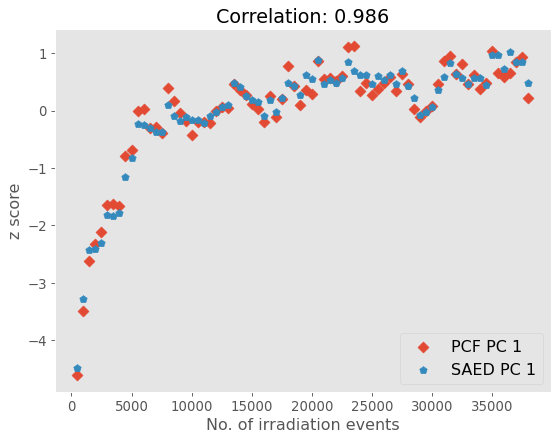

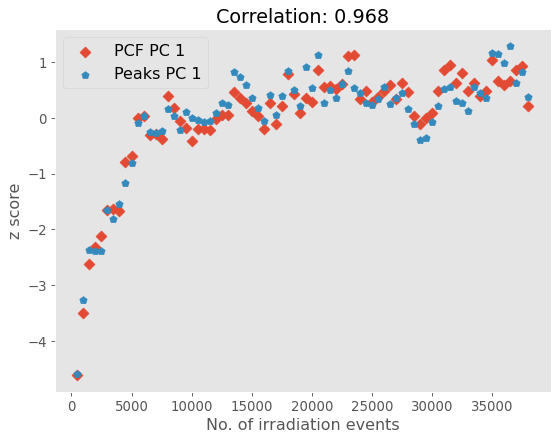

In [20]:
plt.scatter(runs[1:], -zscore(scores_pcf[:,0]), s=50, marker="D")
plt.scatter(runs[1:], -zscore(df_pca["SAED PC 1"]), s=50, marker="p")
plt.legend(["PCF PC 1", "SAED PC 1"])
plt.xlabel("No. of irradiation events")
plt.grid(False)
plt.ylabel("z score")
plt.title("Correlation: {:1.3f}".format(np.corrcoef(df_pca["SAED PC 1"], scores_pcf[:,0])[0,1]))
plt.show()

plt.scatter(runs[1:], -zscore(scores_pcf[:,0]), s=50, marker="D")
plt.scatter(runs[1:], -zscore(df_pks["peaks PC 1"]), s=50, marker="p")
plt.legend(["PCF PC 1", "Peaks PC 1"])
plt.xlabel("No. of irradiation events")
plt.grid(False)
plt.ylabel("z score")
plt.title("Correlation: {:1.3f}".format(np.corrcoef(df_pks["peaks PC 1"], scores_pcf[:,0])[0,1]))
plt.show()

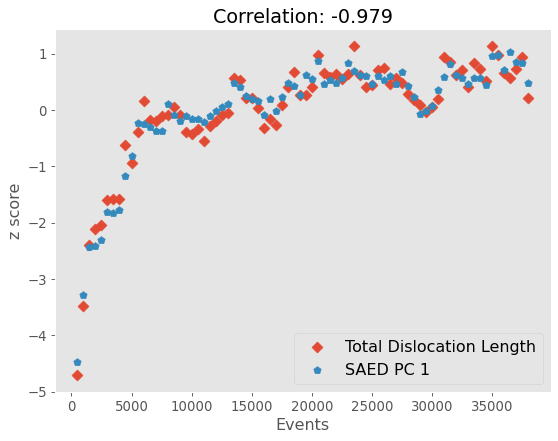

In [65]:
plt.scatter(runs[1:], zscore(df_x_def["DislocationAnalysis.total_line_length"]), s=50, marker="D")
plt.scatter(runs[1:], -zscore(df_pca["SAED PC 1"]), s=50, marker="p")
plt.legend(["Total Dislocation Length", "SAED PC 1"])
plt.xlabel("Events")
plt.grid(False)
plt.ylabel("z score")
plt.title("Correlation: {:1.3f}".format(np.corrcoef(df_pca["SAED PC 1"], df_x_def["DislocationAnalysis.total_line_length"])[0,1]))
plt.show()

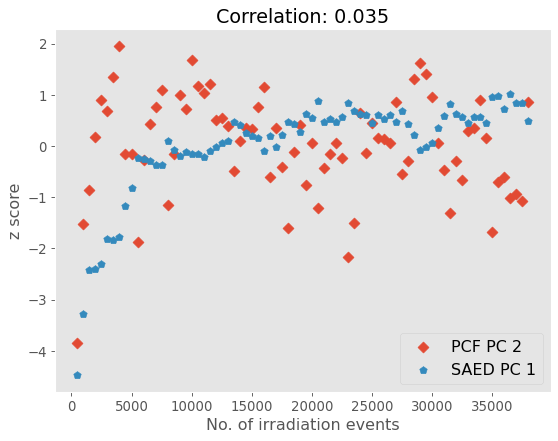

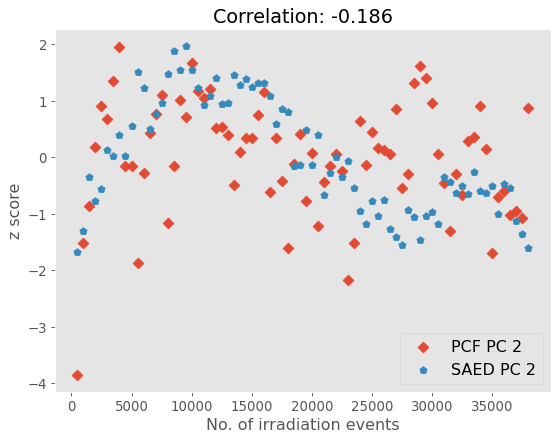

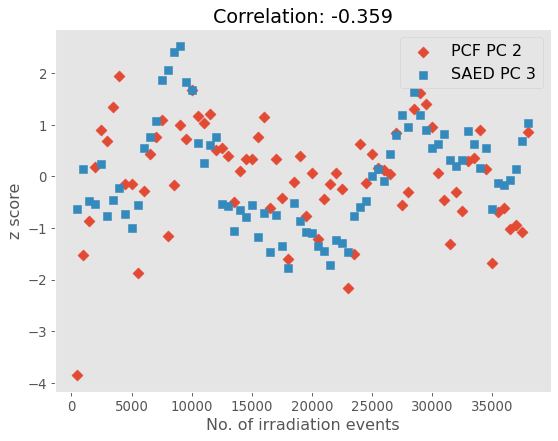

In [66]:
plt.scatter(runs[1:], -zscore(scores_pcf[:,1]), s=50, marker="D")
plt.scatter(runs[1:], -zscore(df_pca["SAED PC 1"]), s=50, marker="p")
plt.legend(["PCF PC 2", "SAED PC 1"])
plt.xlabel("No. of irradiation events")
plt.grid(False)
plt.ylabel("z score")
plt.title("Correlation: {:1.3f}".format(np.corrcoef(df_pca["SAED PC 1"], scores_pcf[:,1])[0,1]))
plt.show()

plt.scatter(runs[1:], -1*zscore(scores_pcf[:,1]), s=50, marker="D")
plt.scatter(runs[1:], zscore(df_pca["SAED PC 2"]), s=50, marker="p")
plt.legend(["PCF PC 2", "SAED PC 2"])
plt.xlabel("No. of irradiation events")
plt.grid(False)
plt.ylabel("z score")
plt.title("Correlation: {:1.3f}".format(np.corrcoef(df_pca["SAED PC 2"], scores_pcf[:,1])[0,1]))
plt.show()

plt.scatter(runs[1:], -1*zscore(scores_pcf[:,1]), s=50, marker="D")
plt.scatter(runs[1:], zscore(df_pca["SAED PC 3"]), s=50, marker="s")
plt.legend(["PCF PC 2", "SAED PC 3"])
plt.xlabel("No. of irradiation events")
plt.grid(False)
plt.ylabel("z score")
plt.title("Correlation: {:1.3f}".format(np.corrcoef(df_pca["SAED PC 3"], scores_pcf[:,1])[0,1]))
plt.show()


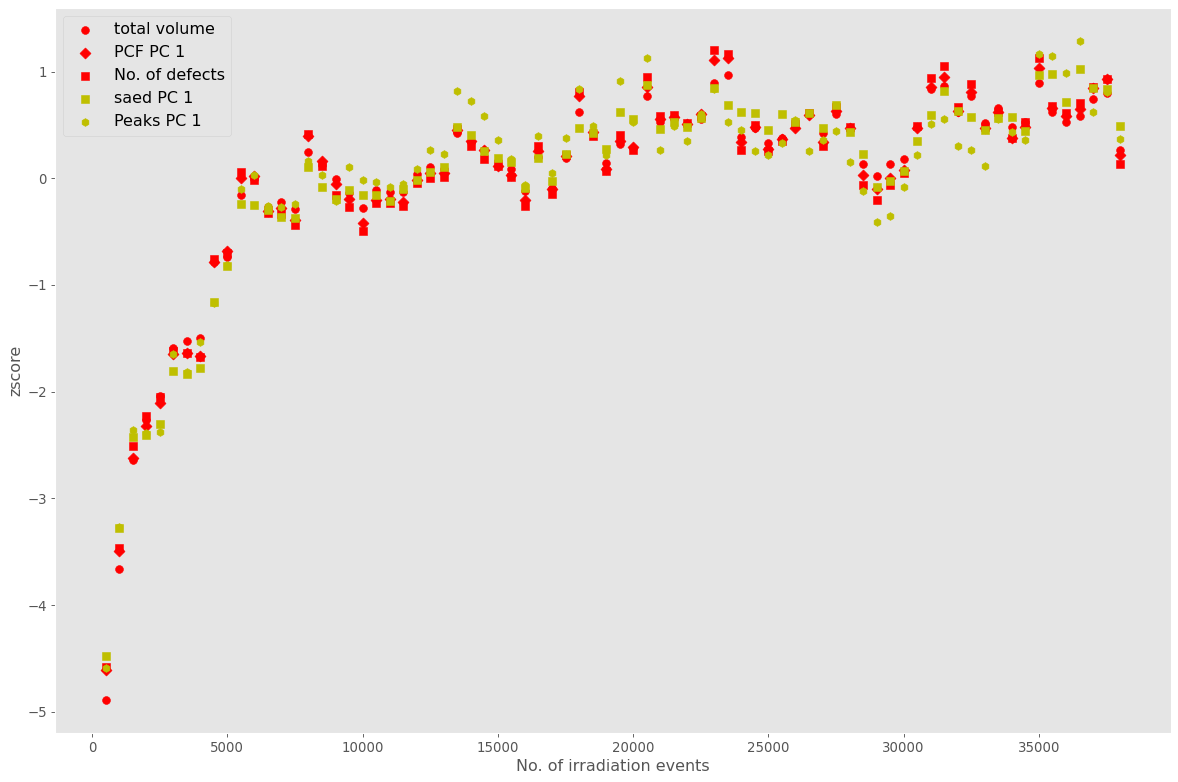

In [67]:
from scipy.stats import zscore
plt.figure(figsize=(18,12))
plt.scatter(runs[1:], zscore(v_tot), s=50, c="r", marker="o")
plt.scatter(runs[1:], -1*zscore(scores_pcf[:,0]), s=50, c="r", marker="D")
plt.scatter(runs[1:], zscore(n_atoms_irr), s=50, c="r", marker="s")
plt.scatter(runs[1:], -zscore(df_pca["SAED PC 1"]), s=50, c="y", marker="s")
plt.scatter(runs[1:], -zscore(df_pks["peaks PC 1"]), s=50, c="y", marker="h")
plt.legend(["total volume", "PCF PC 1", "No. of defects", "saed PC 1", "Peaks PC 1"])
plt.xlabel("No. of irradiation events")
plt.ylabel("zscore")
plt.grid(False)
plt.show()

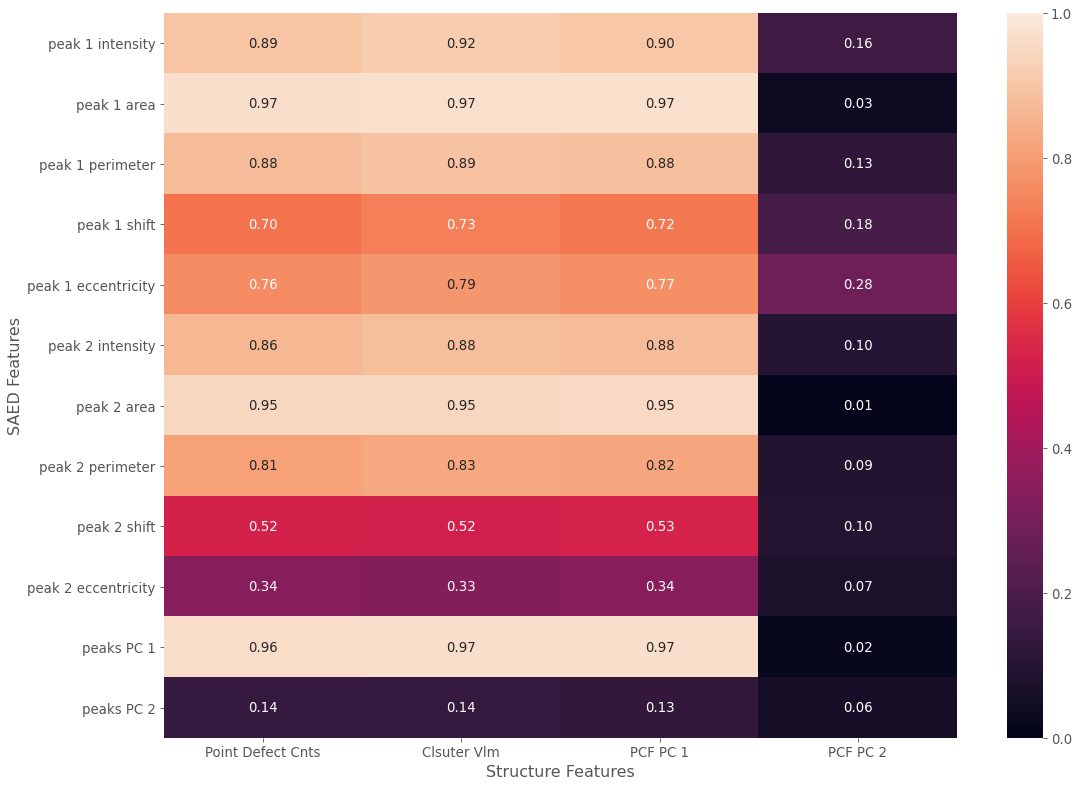

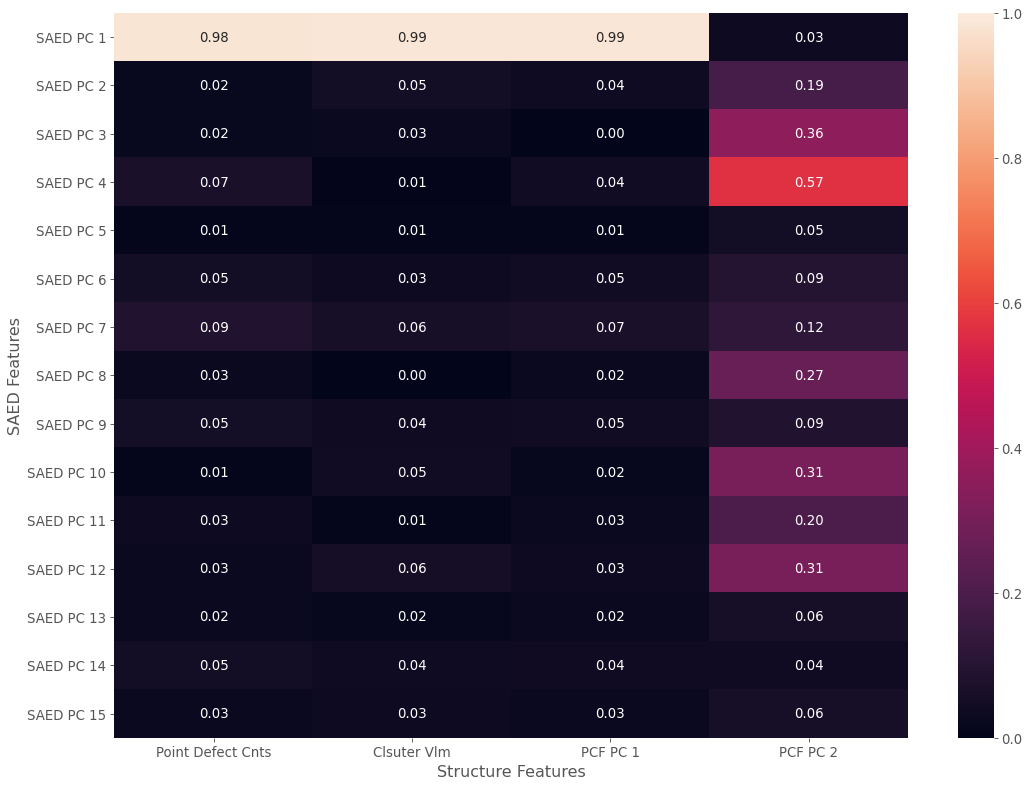

In [68]:
x_lbl = ["Point Defect Cnts", 
         "Clsuter Vlm", 
#          "RDF PC 1", 
#          "RDF PC 2", 
         "PCF PC 1", 
         "PCF PC 2", ]

gen_arr = lambda x: np.asarray(x)[:,None]
df_x = pd.DataFrame(np.concatenate([gen_arr(n_atoms_irr), 
                                    gen_arr(v_tot),  
#                                     gen_arr(scores_rdf_def[:,0]), 
#                                     gen_arr(scores_rdf_def[:,1]), 
                                    gen_arr(scores_pcf[:,0]), 
                                    gen_arr(scores_pcf[:,1])], axis=1), columns=x_lbl)
corr_dct = {}
for lbl in x_lbl:
    corr_dct[lbl] = df_pks.corrwith(df_x[lbl])
        
df_corr = pd.DataFrame(corr_dct).abs()

plt.figure(figsize=(16,12))
plt.rcParams.update({'font.size': 12})
g = sns.heatmap(df_corr, annot=True, fmt=".2f", vmin=0, vmax=1.0)
plt.ylabel("SAED Features")
plt.xlabel("Structure Features")
plt.show()

corr_dct = {}
for lbl in x_lbl:
    corr_dct[lbl] = df_pca.corrwith(df_x[lbl])
        
df_corr = pd.DataFrame(corr_dct).abs()


plt.figure(figsize=(16,12))
plt.rcParams.update({'font.size': 12})
g = sns.heatmap(df_corr, annot=True, fmt=".2f", vmin=0, vmax=1.0)
g.collections[0].colorbar.ax.set_ylim(0.0,1.0)
plt.ylabel("SAED Features")
plt.xlabel("Structure Features")
plt.show()

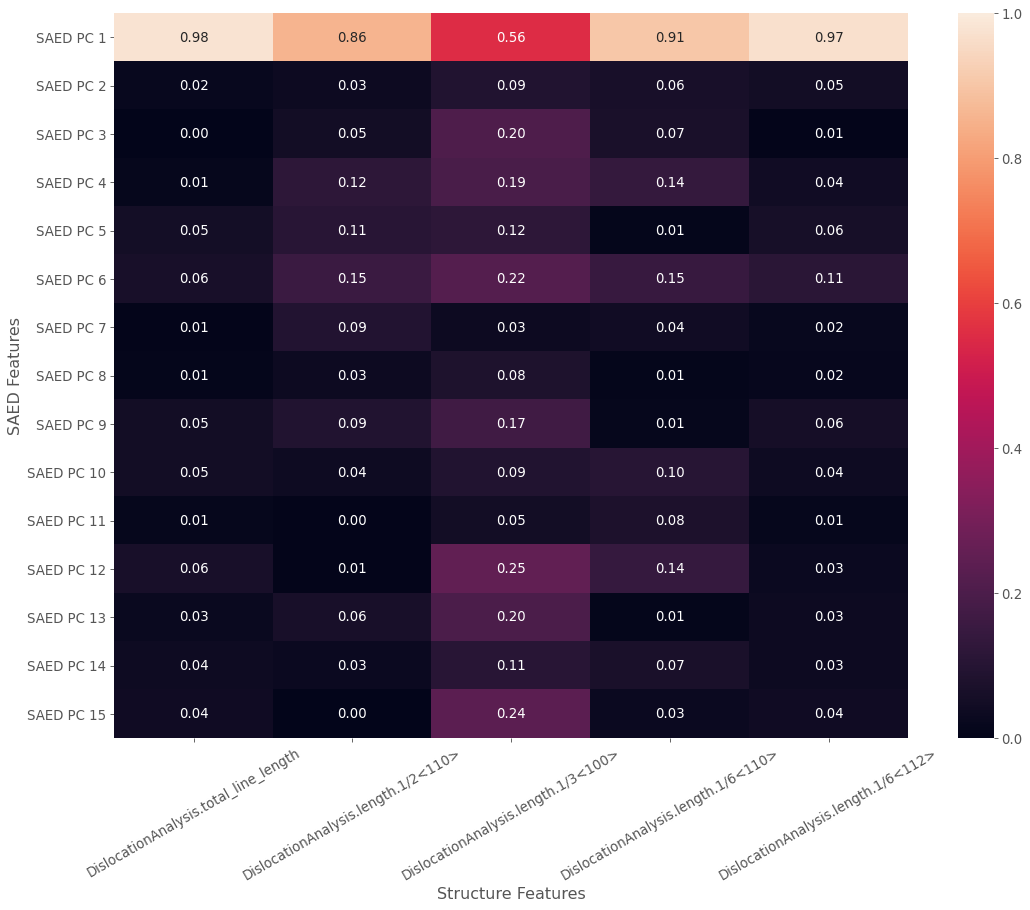

In [92]:
x_def_lbl = ['DislocationAnalysis.total_line_length', 'DislocationAnalysis.length.1/2<110>', 
           'DislocationAnalysis.length.1/3<100>', 'DislocationAnalysis.length.1/6<110>', 
           'DislocationAnalysis.length.1/6<112>']
    
corr_dct = {}
for lbl in x_def_lbl:
    corr_dct[lbl] = df_pca.corrwith(df_x_def[lbl])
        
df_corr = pd.DataFrame(corr_dct).abs()


plt.figure(figsize=(16,12))
plt.rcParams.update({'font.size': 12})
g = sns.heatmap(df_corr, annot=True, fmt=".2f", vmin=0, vmax=1.0)
g.collections[0].colorbar.ax.set_ylim(0.0,1.0)
plt.xticks(rotation=30)
plt.ylabel("SAED Features")
plt.xlabel("Structure Features")
plt.show()

# Model Development

In [70]:
import warnings
warnings.filterwarnings('ignore')
import GPy
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.ensemble import RandomForestRegressor

In [71]:
maerror = lambda y1, y2: np.mean(np.fabs(y1-y2))
correlate = lambda y1, y2: np.corrcoef(np.ravel(y1), np.ravel(y2))[0,1]

get_rbf_kernel = curry(lambda dim, var, scl, ard: GPy.kern.RBF(input_dim=dim, 
                                                    variance=var, 
                                                    lengthscale=scl, 
                                                    ARD=ard))

@curry
def gpr_trn(x_data, y_data, scl=1.0, var=1.0, ard=True):
    
    if type(scl) is not list:
        scl = [scl] * x_data.shape[1] if ard else scl
    
    kernel = get_rbf_kernel(dim=x_data.shape[1], var=var, scl=scl, ard=ard)
    
    model = GPy.models.GPRegression(x_data, y_data, kernel)
    model.optimize();
    return model, kernel


@curry
def gpr_prd(x_data, model):
    y_prd, y_var = model.predict(x_data)
    return y_prd, np.sqrt(y_var)


@curry
def get_pca(x_data, n_comp):
    pca = PCA(n_components=n_comp)
    f_data = pca.fit(x_data)
    return pca

@curry
def gpr_model_full(X_data, y_data, n_comp=3, n_splits=5, n_repeats=10, seed=2652124, scl=None, var=None):

    X = X_data.copy()
    y = y_data.copy()

    rkf = RepeatedKFold(n_splits=n_splits, 
                        n_repeats=n_repeats, 
                        random_state=seed)
    
    generator = rkf.split(X)

    errs_mae = []
    errs_gpr = []
    corrs = []

    for ix, (trn_indx, tst_indx) in enumerate(generator):

        X_trn, X_tst = X[trn_indx], X[tst_indx]
        y_trn, y_tst = y[trn_indx], y[tst_indx]

        pca = get_pca(X_trn, n_comp=n_comp)

        transformer_x = lambda x: pca.transform(x)
        transformer_y = lambda y: y

        x_inp = transformer_x(X_trn)
        y_inp = transformer_y(y_trn)
        
        if var is None:
            var = np.std(y_inp)
            
        if scl is None:
            scl = list(np.sqrt(pca.explained_variance_))
        
        try:
            gpr, rbf = gpr_trn(x_inp, y_inp, 
                               scl=scl, 
                               var=var, 
                               ard=True)

            y_prd_m, y_prd_s = gpr_prd(transformer_x(X_tst), 
                                       gpr)

            errs_mae.append(maerror(y_prd_m, y_tst))
#             corrs.append(correlate(y_prd_m, y_tst))
        except Exception as err:
            print(err)
        
    return errs_mae, errs_gpr, corrs

maerror = lambda y1, y2: np.sqrt(np.mean((y1-y2)**2))

# errs, corrs, model = get_model(x_data, y_data, RandomForestRegressor(), verbose=True)

errs- mean:0.196, std:0.027
cors- 0.967


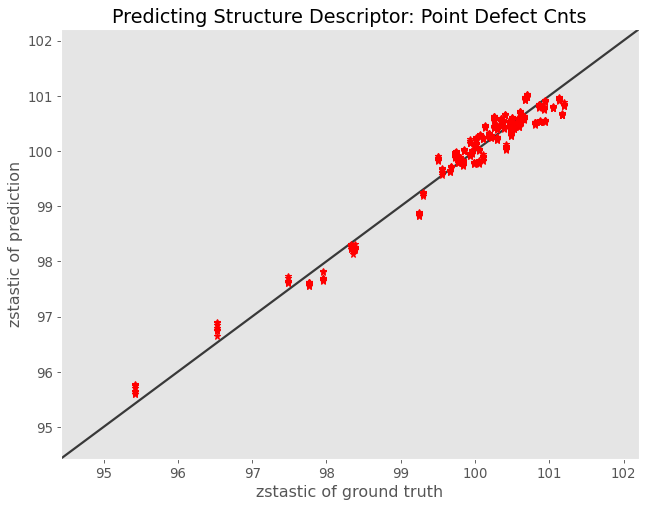

errs- mean:0.173, std:0.044
cors- 0.977


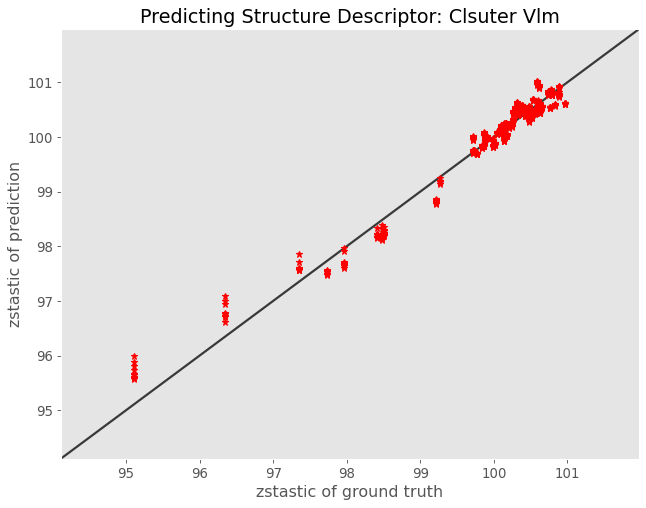

errs- mean:0.173, std:0.025
cors- 0.973


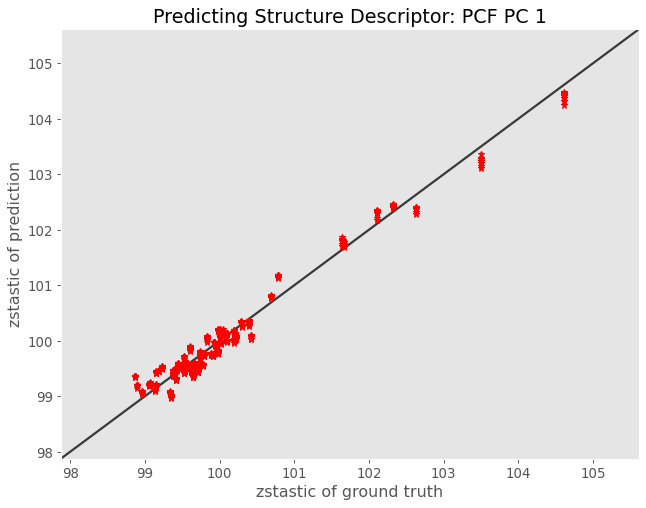

errs- mean:0.614, std:0.245
cors- 0.809


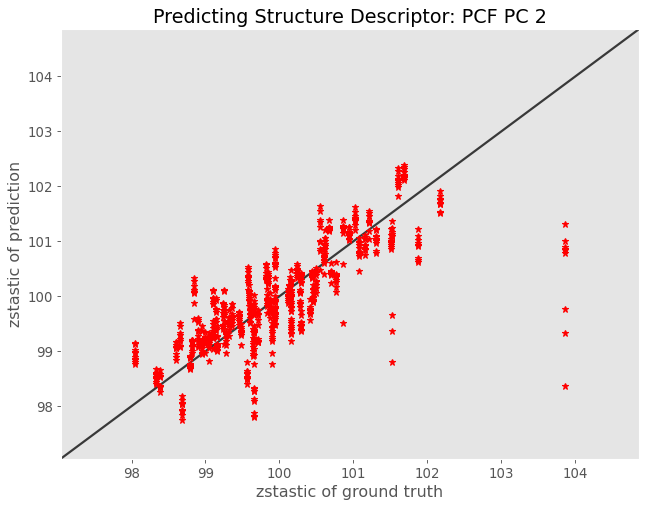

In [72]:
def get_model(X, y, model, n_splits=5, n_repeats=10, verbose=True):
    
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=2652124)
    generator = rkf.split(X)
    errs = []
    corrs = []

    for ix, (trn_indx, tst_indx) in enumerate(generator):

        X_trn, X_tst = X[trn_indx], X[tst_indx]
        y_trn, y_tst = y[trn_indx], y[tst_indx]
        model.fit(X_trn, np.ravel(y_trn))
        y_prd = model.predict(X_tst)

        errs.append(maerror(np.ravel(y_prd), np.ravel(y_tst)))
        corrs.append(np.corrcoef(np.ravel(y_prd), np.ravel(y_tst))[0,1])
        plt.plot(y_tst, y_prd, "*", c="r")
#     if verbose:
    print("errs- mean:{:1.3f}, std:{:1.3f}".format(np.mean(errs), np.std(errs)))
    print("cors- {:1.3f}".format(np.mean(corrs)))
    lims = [y.min()-y.std(), y.max()+y.std()]
    plt.grid(False)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.tight_layout()
    plt.title("Predicting Structure Descriptor: {}".format(iz))
    plt.ylabel("zstastic of prediction")
    plt.xlabel("zstastic of ground truth")
    plt.show()


    return errs, corrs, model

n_comps = {}
n_comps['Point Defect Cnts'] = [1, 2, 3]
n_comps['Clsuter Vlm'] = [1, 2, 3]
n_comps['PCF PC 1'] = [1, 2, 3]

n_comps['PCF PC 2'] = list(range(1, 15))

len_gpr = {}
err_gpr = {}
cor_gpr = {}

for iz in df_x.columns:
    
    cols = ["SAED PC {}".format(i) for i in n_comps[iz]]
    x_data = df_pca[cols].values
    y_data = zscore(df_x[iz])[...,None]+100
    err_gpr[iz], cor_gpr[iz], _ = get_model(X=x_data, 
                                       y=y_data, 
                                       model=Ridge(alpha=10.), 
                                       verbose=True)
    
#     print("mean absolute error: {:1.3f}".format(np.mean(err_gpr[iz])))
#     print("correlation: {:1.3f}".format(np.mean(cor_gpr[iz])))

In [83]:
df_x.to_csv("structure_clusterFeatures.csv")
df_x_def.to_csv("structure_dxaFeatures.csv")
df_pca.to_csv("saed_pcaFeatures.csv")
df_pks.to_csv("saed_peaksFeatures.csv")

In [84]:
df_x_def

,Timestep,DislocationAnalysis.cell_volume,DislocationAnalysis.counts.BCC,DislocationAnalysis.counts.CubicDiamond,DislocationAnalysis.counts.FCC,DislocationAnalysis.counts.HCP,DislocationAnalysis.counts.HexagonalDiamond,DislocationAnalysis.counts.OTHER,DislocationAnalysis.length.1/2<110>,DislocationAnalysis.length.1/3<100>,...,DislocationAnalysis.length.1/6<110>,DislocationAnalysis.length.1/6<112>,DislocationAnalysis.length.other,DislocationAnalysis.total_line_length,PolyhedralTemplateMatching.counts.BCC,PolyhedralTemplateMatching.counts.FCC,PolyhedralTemplateMatching.counts.HCP,PolyhedralTemplateMatching.counts.ICO,PolyhedralTemplateMatching.counts.OTHER,PolyhedralTemplateMatching.counts.SC
0,20000.0,47812740.0,0.0,0.0,3898161.0,16670.0,0.0,85169.0,618.218567,1323.302979,...,4634.693359,23232.117188,791.553894,31008.867188,364.0,3912410.0,20919.0,6.0,66300.0,1.0
1,40000.0,47812740.0,0.0,0.0,3846586.0,29333.0,0.0,124081.0,1013.582092,1876.629761,...,7696.310547,34864.773438,1089.544434,47331.039062,571.0,3867494.0,36314.0,2.0,95616.0,3.0
2,60000.0,47812740.0,0.0,0.0,3802563.0,37601.0,0.0,159836.0,1435.168945,2396.071045,...,10655.726562,44546.601562,1438.534180,61574.656250,740.0,3828921.0,46106.0,1.0,124230.0,2.0
3,80000.0,47812740.0,0.0,0.0,3791003.0,44168.0,0.0,164829.0,1406.988281,2481.128418,...,12118.016602,46710.617188,1588.189941,65353.898438,690.0,3817389.0,53653.0,4.0,128262.0,2.0
4,100000.0,47812740.0,0.0,0.0,3783088.0,46513.0,0.0,170399.0,1537.263916,2350.049561,...,12453.992188,47978.382812,1167.986206,66294.007812,680.0,3810220.0,56349.0,2.0,132747.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,1440000.0,47812740.0,0.0,0.0,3668523.0,80895.0,0.0,250582.0,2266.343506,2733.167480,...,19345.847656,74032.921875,2052.396484,101913.289062,943.0,3702517.0,96188.0,1.0,200348.0,3.0
72,1460000.0,47812740.0,0.0,0.0,3663073.0,78886.0,0.0,258041.0,2479.874512,2841.007812,...,17599.527344,74537.554688,2028.339478,100708.906250,1026.0,3698752.0,94449.0,2.0,205771.0,0.0
73,1480000.0,47812740.0,0.0,0.0,3657805.0,91140.0,0.0,251055.0,2381.945068,2687.767334,...,19824.535156,74188.554688,2441.896729,102988.484375,1052.0,3692603.0,107496.0,1.0,198848.0,0.0
74,1500000.0,47812740.0,0.0,0.0,3655039.0,92412.0,0.0,252549.0,2138.787354,2706.486816,...,20019.132812,76675.382812,2718.486084,105815.898438,1115.0,3689708.0,108772.0,2.0,200403.0,0.0


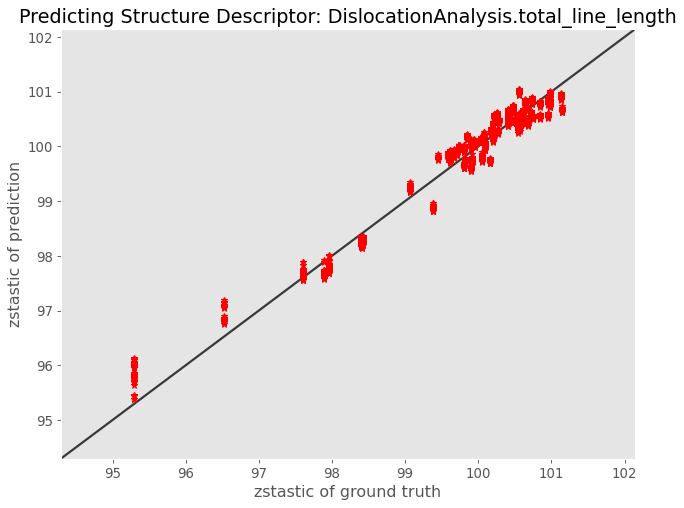

errs- mean:0.214, std:0.038
cors- 0.965

Name : GP regression
Objective : 5.377088547484433
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |      3084.0792505601  |      +ve      |        
  rbf.lengthscale          |   1515.4447646397082  |      +ve      |        
  Gaussian_noise.variance  |  0.03927059100981096  |      +ve      |        


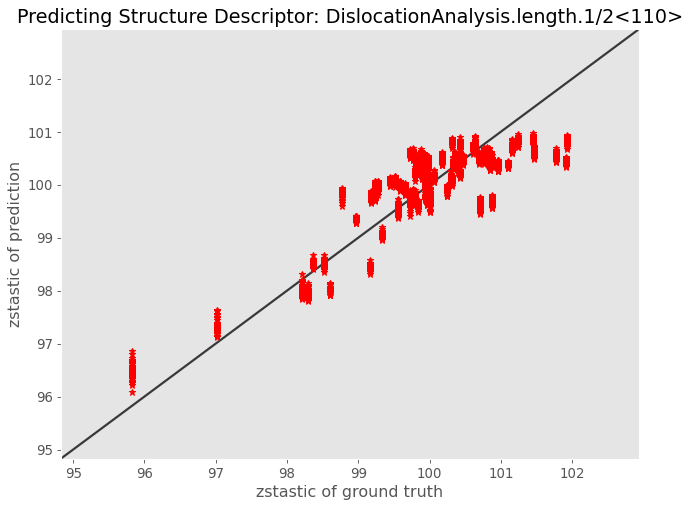

errs- mean:0.532, std:0.089
cors- 0.807

Name : GP regression
Objective : 57.35031168091916
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   10023.394868025716  |      +ve      |        
  rbf.lengthscale          |    6157.469593452313  |      +ve      |        
  Gaussian_noise.variance  |  0.26165273502475894  |      +ve      |        


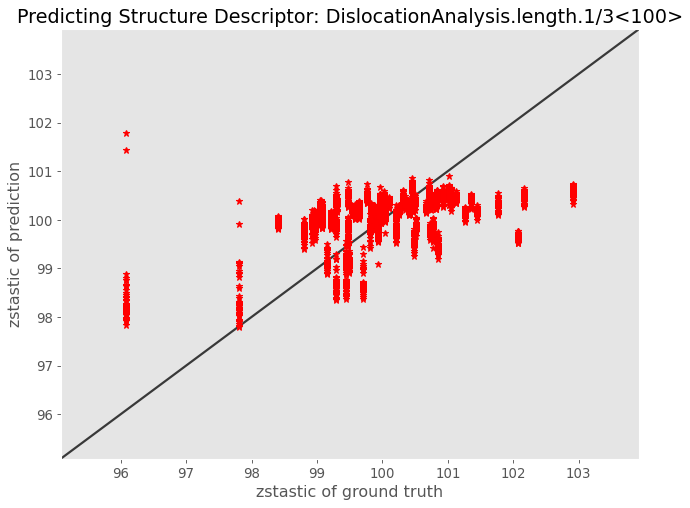

errs- mean:0.851, std:0.180
cors- 0.496

Name : GP regression
Objective : 84.72233201940571
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |  25624.485765854224  |      +ve      |        
  rbf.lengthscale          |  14146.095527669659  |      +ve      |        
  Gaussian_noise.variance  |  0.6960316837144078  |      +ve      |        


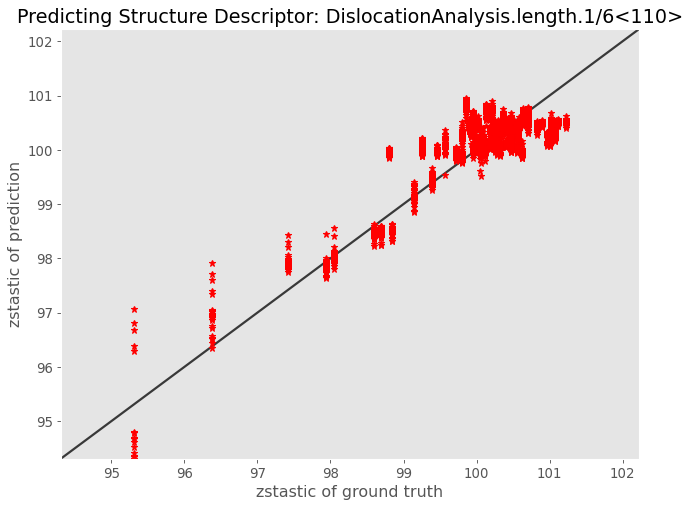

errs- mean:0.429, std:0.083
cors- 0.833

Name : GP regression
Objective : 41.029800224000894
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |    2568.063849537779  |      +ve      |        
  rbf.lengthscale          |    848.0900251782759  |      +ve      |        
  Gaussian_noise.variance  |  0.12922879480735006  |      +ve      |        


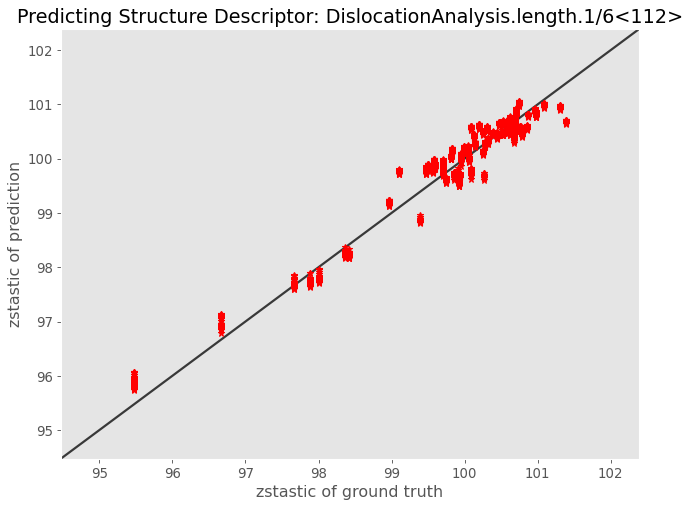

errs- mean:0.247, std:0.043
cors- 0.953

Name : GP regression
Objective : 13.30361803115536
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |     7879.439812913721  |      +ve      |        
  rbf.lengthscale          |     4725.864158470061  |      +ve      |        
  Gaussian_noise.variance  |  0.055366266734931856  |      +ve      |        


In [85]:
mu = 1
s = 10
n_splits = 5
n_repeats = 50
seed = 8969764
n_comp=10

# n_comps = {}
n_comps = [1, 2, 3]
# n_comps['Clsuter Vlm'] = [1, 2, 3]
# n_comps['PCF PC 1'] = [1, 2, 3]
# n_comps['PCF PC 2'] = [1,2,3,4,5,6,7,8,9,10,11,12]

len_gpr = {}
err_gpr = {}
cor_gpr = {}

for iz in ['DislocationAnalysis.total_line_length', 'DislocationAnalysis.length.1/2<110>', 
           'DislocationAnalysis.length.1/3<100>', 'DislocationAnalysis.length.1/6<110>', 
           'DislocationAnalysis.length.1/6<112>']:
    
    cols = ["SAED PC {}".format(i) for i in n_comps]
    x_data = df_pca[cols].values
    y_data = zscore(df_x_def[iz])[...,None]+100

    X = x_data.copy()
    y = y_data.copy()

    rkf = RepeatedKFold(n_splits=n_splits, 
                        n_repeats=n_repeats, 
                        random_state=seed)
    generator = rkf.split(X)  

    err_gpr[iz] = []
    cor_gpr[iz] = []
    len_gpr[iz] = []

    for trn_indx, tst_indx in generator:


        X_trn, X_tst = X[trn_indx], X[tst_indx]
        y_trn, y_tst = y[trn_indx], y[tst_indx]

        transformer_x = lambda x: x
        transformer_y = lambda y: y

        x_inp = transformer_x(X_trn)
        y_inp = transformer_y(y_trn)

        scl = list(np.std(x_inp, axis=0))
        var = np.var(y_inp)
        
        try:
            gpr, rbf = gpr_trn(x_inp, y_inp, 
                               scl=500, 
                               var=10, 
                               ard=False)

            y_prd_m, y_prd_s = gpr_prd(transformer_x(X_tst), 
                                       gpr)
            err_gpr[iz].append(maerror(y_prd_m, y_tst))
            cor_gpr[iz].append(correlate(y_prd_m, y_tst))
            len_gpr[iz].append(rbf.lengthscale[0])
            plt.plot(y_tst, y_prd_m, "*", c="r")

        except Exception as err:
            print(err)

    lims = [y.min()-y.std(), y.max()+y.std()]
    plt.grid(False)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.tight_layout()
    plt.title("Predicting Structure Descriptor: {}".format(iz))
    plt.ylabel("zstastic of prediction")
    plt.xlabel("zstastic of ground truth")
    plt.show()

    print("errs- mean:{:1.3f}, std:{:1.3f}".format(np.mean(err_gpr[iz]), np.std(err_gpr[iz])))
    print("cors- {:1.3f}".format(np.mean(cor_gpr[iz])))   
    print(gpr)

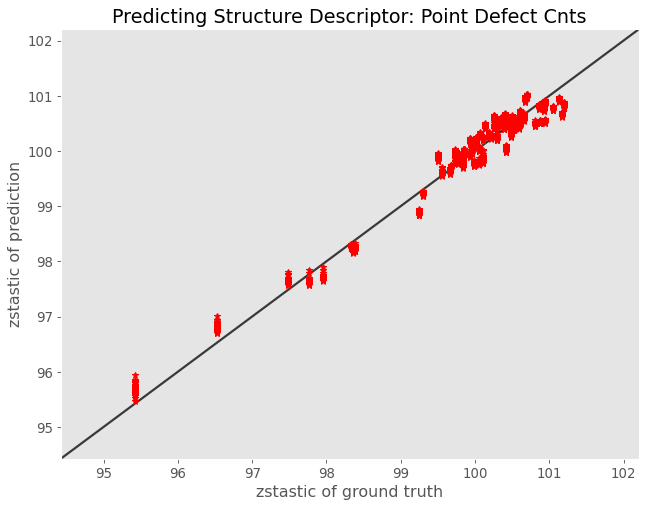

errs- mean:0.197, std:0.031
cors- 0.967

Name : GP regression
Objective : -0.4243310116356156
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |    7328.484870440169  |      +ve      |        
  rbf.lengthscale          |     4466.00699710465  |      +ve      |        
  Gaussian_noise.variance  |  0.03417317691020334  |      +ve      |        


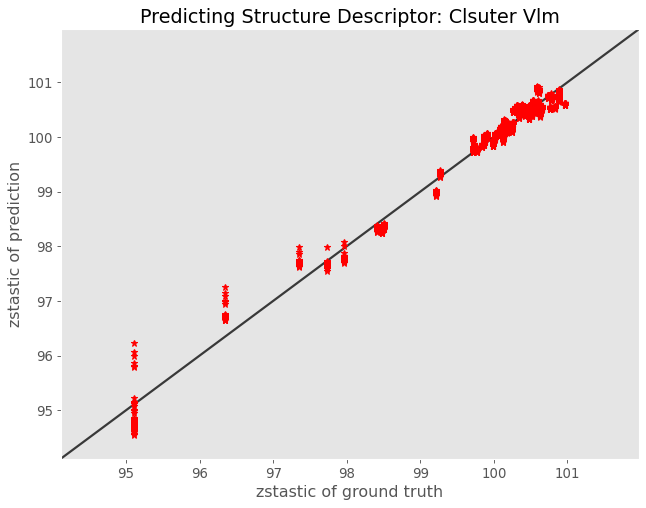

errs- mean:0.150, std:0.038
cors- 0.981

Name : GP regression
Objective : -13.507373272636372
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    2778.1611714064793  |      +ve      |        
  rbf.lengthscale          |     1198.499202610365  |      +ve      |        
  Gaussian_noise.variance  |  0.019464198337699936  |      +ve      |        


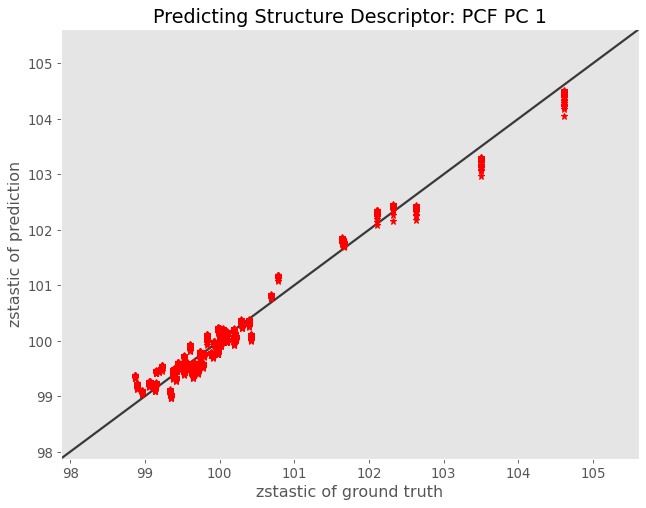

errs- mean:0.174, std:0.029
cors- 0.973

Name : GP regression
Objective : -4.80665436530731
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |     505205.7702779648  |      +ve      |        
  rbf.lengthscale          |     32103.46687943319  |      +ve      |        
  Gaussian_noise.variance  |  0.027758187739047258  |      +ve      |        


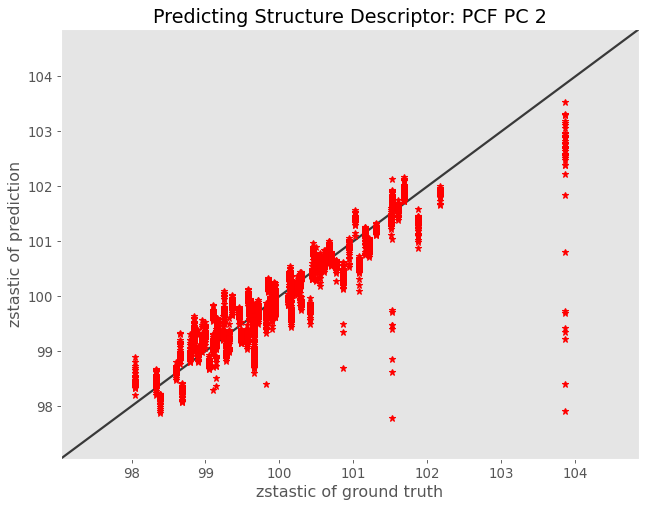

errs- mean:0.350, std:0.226
cors- 0.924

Name : GP regression
Objective : 55.47343530099706
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    5281.7304580025875  |      +ve      |        
  rbf.lengthscale          |     533.0357281025787  |      +ve      |        
  Gaussian_noise.variance  |  0.046820160044269844  |      +ve      |        


In [43]:
mu = 1
s = 10
n_splits = 5
n_repeats = 50
seed = 8969764
n_comp=10

n_comps = {}
n_comps['Point Defect Cnts'] = [1, 2, 3]
n_comps['Clsuter Vlm'] = [1, 2, 3]
n_comps['PCF PC 1'] = [1, 2, 3]
n_comps['PCF PC 2'] = [1,2,3,4,5,6,7,8,9,10,11,12]

len_gpr = {}
err_gpr = {}
cor_gpr = {}

for iz in df_x.columns:
    
    cols = ["SAED PC {}".format(i) for i in n_comps[iz]]
    x_data = df_pca[cols].values
    y_data = zscore(df_x[iz])[...,None]+100

    X = x_data.copy()
    y = y_data.copy()

    rkf = RepeatedKFold(n_splits=n_splits, 
                        n_repeats=n_repeats, 
                        random_state=seed)
    generator = rkf.split(X)  

    err_gpr[iz] = []
    cor_gpr[iz] = []
    len_gpr[iz] = []

    for trn_indx, tst_indx in generator:


        X_trn, X_tst = X[trn_indx], X[tst_indx]
        y_trn, y_tst = y[trn_indx], y[tst_indx]

        transformer_x = lambda x: x
        transformer_y = lambda y: y

        x_inp = transformer_x(X_trn)
        y_inp = transformer_y(y_trn)

        scl = list(np.std(x_inp, axis=0))
        var = np.var(y_inp)
        
        try:
            gpr, rbf = gpr_trn(x_inp, y_inp, 
                               scl=500, 
                               var=10, 
                               ard=False)

            y_prd_m, y_prd_s = gpr_prd(transformer_x(X_tst), 
                                       gpr)
            err_gpr[iz].append(maerror(y_prd_m, y_tst))
            cor_gpr[iz].append(correlate(y_prd_m, y_tst))
            len_gpr[iz].append(rbf.lengthscale[0])
            plt.plot(y_tst, y_prd_m, "*", c="r")

        except Exception as err:
            print(err)

    lims = [y.min()-y.std(), y.max()+y.std()]
    plt.grid(False)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.tight_layout()
    plt.title("Predicting Structure Descriptor: {}".format(iz))
    plt.ylabel("zstastic of prediction")
    plt.xlabel("zstastic of ground truth")
    plt.show()

    print("errs- mean:{:1.3f}, std:{:1.3f}".format(np.mean(err_gpr[iz]), np.std(err_gpr[iz])))
    print("cors- {:1.3f}".format(np.mean(cor_gpr[iz])))   
    print(gpr)

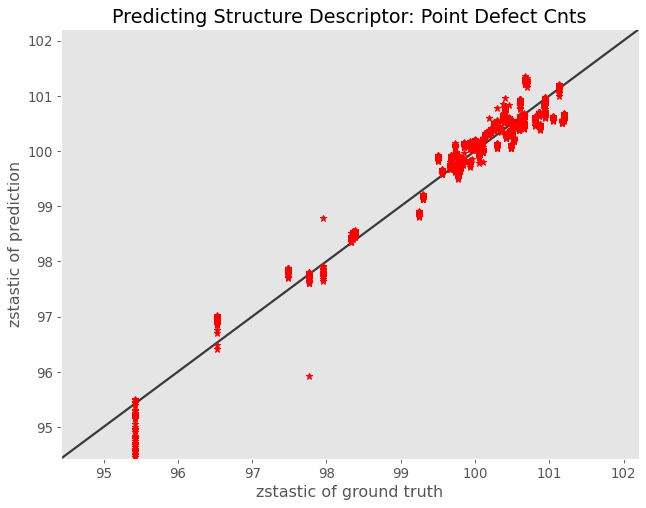

errs- mean:0.243, std:0.052
cors- 0.954

Name : GP regression
Objective : 15.476747223932207
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   3388924.8468742864  |      +ve      |        
  rbf.lengthscale          |   1980303.2469448945  |      +ve      |        
  Gaussian_noise.variance  |  0.05797272751507274  |      +ve      |        


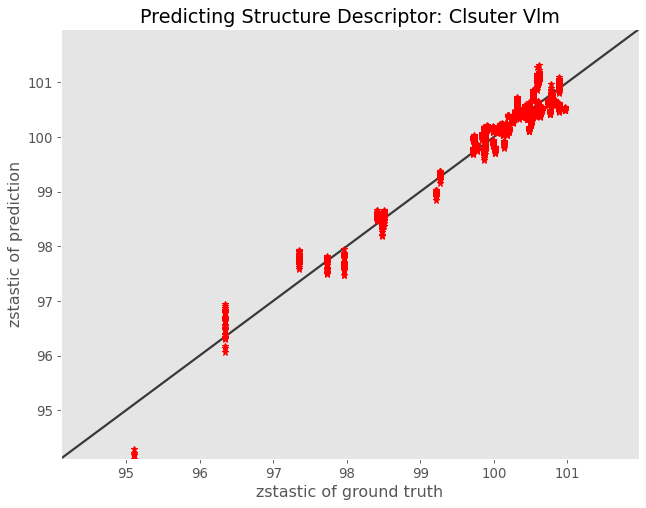

errs- mean:0.229, std:0.077
cors- 0.962

Name : GP regression
Objective : 4.0146007050460355
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   3110.5790345208493  |      +ve      |        
  rbf.lengthscale          |   23261.200942702555  |      +ve      |        
  Gaussian_noise.variance  |  0.03503341300264459  |      +ve      |        


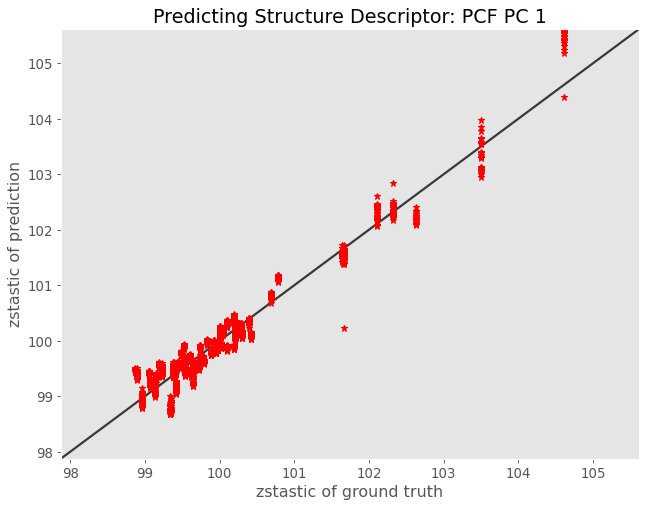

errs- mean:0.285, std:0.631
cors- 0.950

Name : GP regression
Objective : 11.162669299677532
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |    56706.46239281207  |      +ve      |        
  rbf.lengthscale          |   276028.52753259905  |      +ve      |        
  Gaussian_noise.variance  |  0.05009369391740955  |      +ve      |        


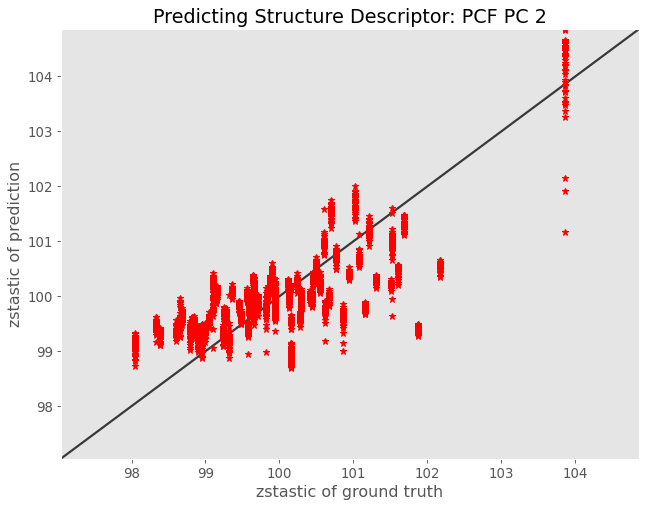

errs- mean:0.759, std:0.846
cors- 0.676

Name : GP regression
Objective : 71.21265529422891
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   41917.605744558634  |      +ve      |        
  rbf.lengthscale          |    29106.50459574195  |      +ve      |        
  Gaussian_noise.variance  |  0.33790240582095005  |      +ve      |        


In [44]:
mu = 1
s = 10
n_splits = 5
n_repeats = 50
seed = 8969764
n_comp=10

n_comps = {}
n_comps['Point Defect Cnts'] = [1, 2]
n_comps['Clsuter Vlm'] = [1, 2]
n_comps['PCF PC 1'] = [1, 2]
n_comps['PCF PC 2'] = [1,2]

len_gpr_pks = {}
err_gpr_pks = {}
cor_gpr_pks = {}

for iz in df_x.columns:
    
    cols = ["peaks PC {}".format(i) for i in n_comps[iz]]
    x_data = df_pks[cols].values
    y_data = zscore(df_x[iz])[...,None]+100

    X = x_data.copy()
    y = y_data.copy()

    rkf = RepeatedKFold(n_splits=n_splits, 
                        n_repeats=n_repeats, 
                        random_state=seed)
    generator = rkf.split(X)  

    err_gpr_pks[iz] = []
    cor_gpr_pks[iz] = []
    len_gpr_pks[iz] = []

    for trn_indx, tst_indx in generator:


        X_trn, X_tst = X[trn_indx], X[tst_indx]
        y_trn, y_tst = y[trn_indx], y[tst_indx]

        transformer_x = lambda x: x
        transformer_y = lambda y: y

        x_inp = transformer_x(X_trn)
        y_inp = transformer_y(y_trn)

        scl = list(np.std(x_inp, axis=0))
        var = np.var(y_inp)
        
        try:
            gpr, rbf = gpr_trn(x_inp, y_inp, 
                               scl=500, 
                               var=10, 
                               ard=False)

            y_prd_m, y_prd_s = gpr_prd(transformer_x(X_tst), 
                                       gpr)
            err_gpr_pks[iz].append(maerror(y_prd_m, y_tst))
            cor_gpr_pks[iz].append(correlate(y_prd_m, y_tst))
            len_gpr_pks[iz].append(rbf.lengthscale[0])
            plt.plot(y_tst, y_prd_m, "*", c="r")

        except Exception as err:
            print(err)

    lims = [y.min()-y.std(), y.max()+y.std()]
    plt.grid(False)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.tight_layout()
    plt.title("Predicting Structure Descriptor: {}".format(iz))
    plt.ylabel("zstastic of prediction")
    plt.xlabel("zstastic of ground truth")
    plt.show()

    print("errs- mean:{:1.3f}, std:{:1.3f}".format(np.mean(err_gpr_pks[iz]), np.std(err_gpr_pks[iz])))
    print("cors- {:1.3f}".format(np.mean(cor_gpr_pks[iz])))   
    print(gpr)

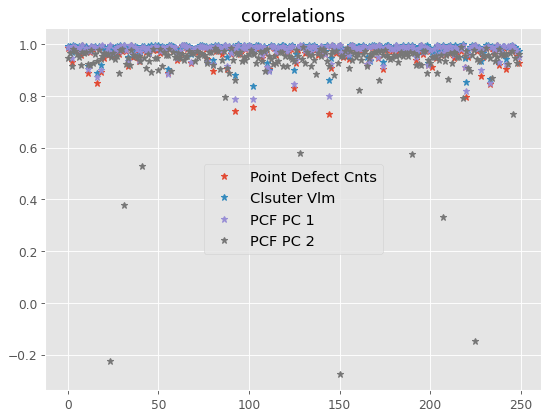

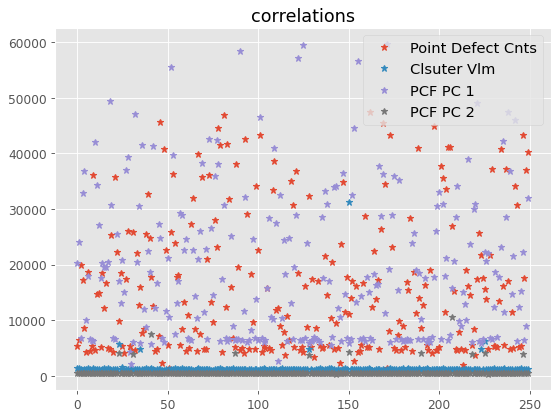

In [218]:
for iz in df_x.columns:
    plt.plot(cor_gpr[iz], "*")
plt.legend(df_x.columns)
plt.title("correlations")
plt.show()

for iz in df_x.columns:
    plt.plot(len_gpr[iz], "*")
plt.legend(df_x.columns)
plt.title("correlations")
plt.show()

In [ ]:
#     plt.plot(zscore(cor_gpr[iz]), "*")
#     plt.plot(zscore(cor_gpr[1]), "s")
#     plt.legend(["PCF PC 1", "PCF PC 2"])
#     plt.title("correlations")
#     plt.show()

#     plt.plot(zscore(err_gpr[0]), "*")
#     plt.plot(zscore(err_gpr[1]), "s")
#     plt.legend(["PCF PC 1", "PCF PC 2"])
#     plt.title("Mean Abbsolute Errors")
#     plt.show()

#     plt.plot(zscore(len_gpr[0]), "*")
#     plt.plot(zscore(len_gpr[1]), "s")
#     plt.legend(["PCF PC 1", "PCF PC 2"])
#     plt.show("GPR Length Scales")
#     plt.show()

In [149]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel, WhiteKernel


iz = 1
n_c = 15
cols = ["SAED PC {}".format(i+1) for i in range(n_c)]


X = df_pca[cols].values
y = zscore(scores_pcf[:,iz])[...,None] 

rkf = RepeatedKFold(n_splits=5, 
                    n_repeats=10, 
                    random_state=989345)
generator = rkf.split(X)

kernel = RBF(length_scale=1)
# kernel = Matern(length_scale=20.0, nu=10)

len_gpr = {}
err_gpr = {}
cor_gpr = {}

err_gpr[iz] = []
cor_gpr[iz] = []
len_gpr[iz] = []
# trn_indx, tst_indx = next(generator)
for trn_indx, tst_indx in generator:
    X_trn, X_tst = X[trn_indx], X[tst_indx]
    y_trn, y_tst = y[trn_indx], y[tst_indx]

    model = GaussianProcessRegressor(kernel=kernel, alpha=.1, n_restarts_optimizer=10)
    model.fit(X_trn, y_trn)
    y_prd_m = model.predict(X_tst, return_std=False)
#     print(maerror(y_prd_m, y_tst))
#     print(correlate(y_prd_m, y_tst))
#     print(model.kernel_)
    err_gpr[iz].append(maerror(y_prd_m, y_tst))
    cor_gpr[iz].append(correlate(y_prd_m, y_tst))
    len_gpr[iz].append(model.kernel_.length_scale)
    
print("mean absolute error: {:1.3f}".format(np.mean(err_gpr[iz])))
print("correlation: {:1.3f}".format(np.mean(cor_gpr[iz])))
print("length: {:1.3f}".format(np.mean(len_gpr[iz])))

mean absolute error: 0.351
correlation: 0.832
length: 43.659


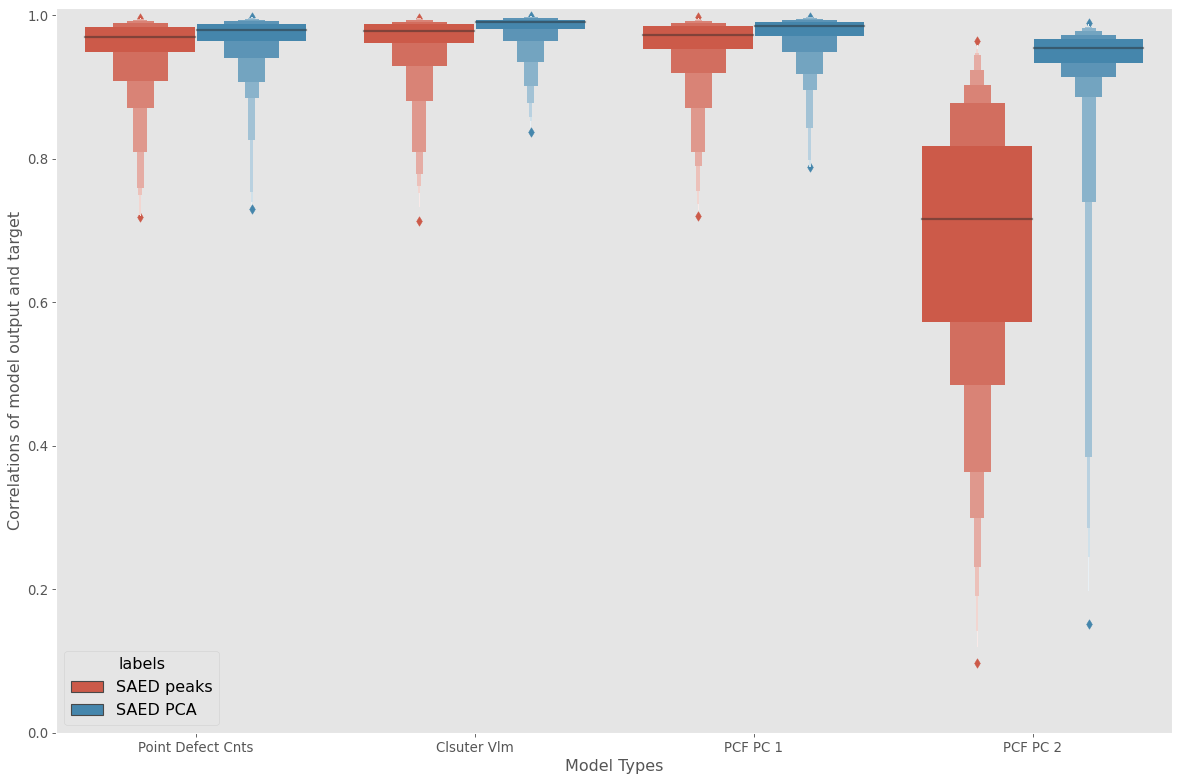

In [66]:
df = pd.DataFrame()
df_val = []
df_key = []

for k in err_gpr_pks:
    df_val.append(cor_gpr_pks[k])
    df_key.append([k] * len(err_gpr_pks[k]))

for k in err_gpr:
    df_val.append(cor_gpr[k])
    df_key.append([k] * len(err_gpr[k]))

    
df = pd.DataFrame()   
df["Correlations"] = np.fabs(np.ravel(df_val))
df["Model Types"] = np.ravel(df_key)

df["labels"] = ["SAED peaks"]*1000+["SAED PCA"]*1000

plt.figure(figsize=(18,12))
g = sns.boxenplot(y="Correlations", x="Model Types", hue="labels", data=df)
# g.set_xticklabels(labels=y_labels,rotation=30)
# plt.title("Comparing models")
plt.ylabel("Correlations of model output and target")
plt.grid(True)
plt.grid(False)
plt.ylim([0.0, 1.01])
plt.show()

SAED PC 4 0.6839750649267513 0.19384618120520092
SAED PC 7 0.23176146193249839 0.09561812981439163
SAED PC 3 0.19877452138907034 0.07642086756684391


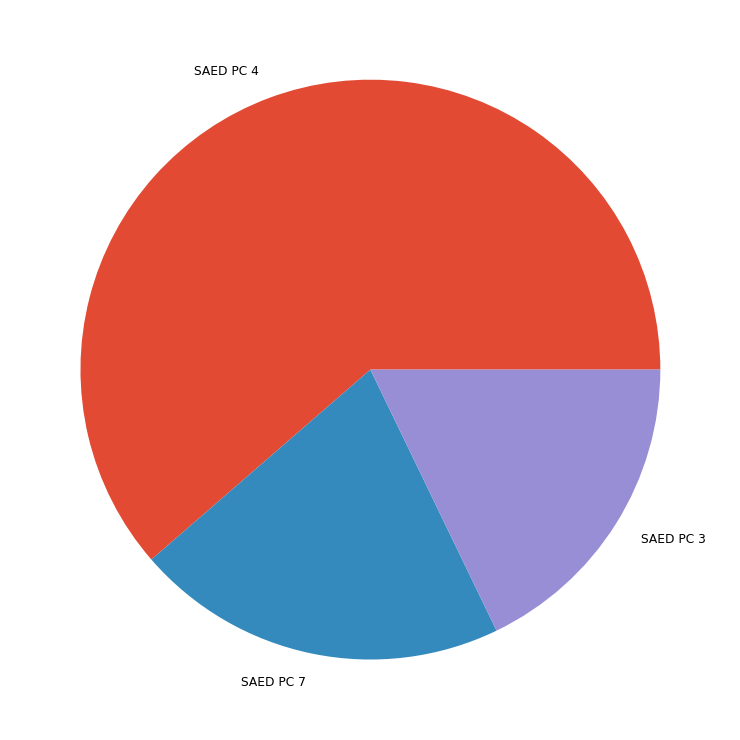

In [150]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model, X_tst, y_tst, n_repeats=100, random_state=0)

pie_lbl = []
pie_val = []
for ix in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[ix] - 2 * r.importances_std[ix] > 0:
        pie_val.append(r.importances_mean[ix])
        pie_lbl.append(cols[ix])
        print(cols[ix], r.importances_mean[ix], r.importances_std[ix])


plt.figure(figsize=(16,12))
plt.rcParams.update({'font.size':11})
plt.pie(pie_val, labels=pie_lbl)
plt.show()

In [107]:
# import xgboost as xg 

# cols = ["PC {}".format(i+1) for i in range(15)]
# X, y = df_pca[cols].values, zscore(scores_pcf[:,1])[...,None] 
  
# # Splitting 
# train_X, test_X, train_y, test_y = train_test_split(X, y, 
#                       test_size = 0.6, random_state = 123) 

# xgb_r = xg.XGBRegressor(objective ='reg:squarederror', 
#                   n_estimators = 10000, seed = 123, gamma=1, learning_rate=0.1) 
  
# # Fitting the model 
# xgb_r.fit(train_X, train_y) 
  
# # Predict the model 
# pred_y = xgb_r.predict(test_X) 


# plt.plot(test_y, pred_y, "*", c="r")
        
# lims = [y.min()-y.std(), y.max()+y.std()]
# plt.grid(False)
# plt.xlim(lims)
# plt.ylim(lims)
# plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
# plt.tight_layout()
# plt.show()
# print("mean absolute error: {:1.3f}".format(maerror(pred_y, test_y)))
# print("correlation: {:1.3f}".format(correlate(pred_y, test_y)))

In [28]:
X_pks = df_pks.values
X_pca = df_pca.values[:,:5]

Point Defect Cnts, mae: 0.028, corr:0.947
Defect Clstr Cnts, mae: 0.069, corr:0.195
Mean Clstr Vlm, mae: 0.068, corr:0.830
Std of Clstr Vlm, mae: 0.065, corr:0.920
1st NN  dist, mae: 0.041, corr:0.577
2nd NN dist, mae: 0.041, corr:0.410
5th NN dist, mae: 0.041, corr:0.122


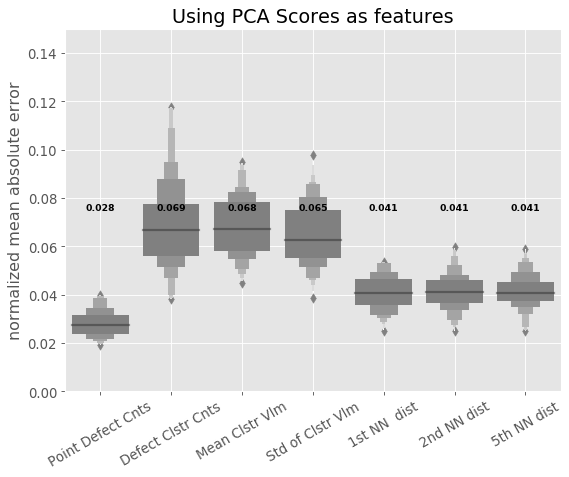

Point Defect Cnts, mae: 0.022, corr:0.972
Defect Clstr Cnts, mae: 0.067, corr:0.278
Mean Clstr Vlm, mae: 0.060, corr:0.862
Std of Clstr Vlm, mae: 0.055, corr:0.933
1st NN  dist, mae: 0.040, corr:0.608
2nd NN dist, mae: 0.039, corr:0.504
5th NN dist, mae: 0.040, corr:0.204


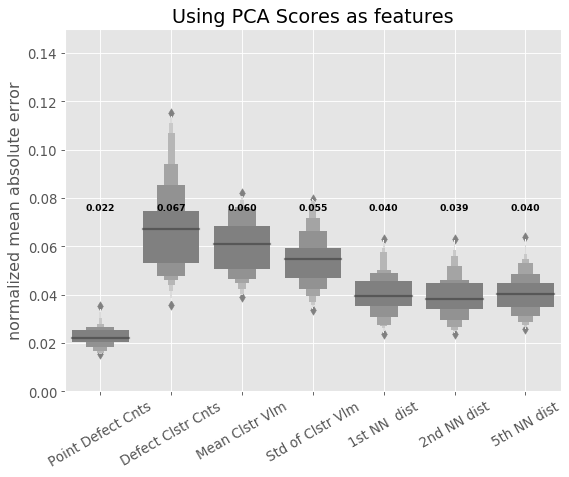

In [91]:
x = df_pks.values[:,:5]

err_dct = {}
for l in x_lbl:
    y = df_x[l]
    errs, corrs, model = get_model(x, y, Ridge(alpha=10.0), verbose=False)
    print("{}, mae: {:1.3f}, corr:{:1.3f}".format(l, np.mean(errs) / np.mean(y), np.mean(corrs), "\n"))
    err_dct[l] = np.asarray(errs)/ np.mean(y)
    
df = pd.DataFrame(err_dct)
g = sns.boxenplot(data=df, color='gray')
g.set_xticklabels(labels=x_lbl,rotation=30)
plt.title("Using PCA Scores as features")
plt.ylabel("normalized mean absolute error")
medians = df.mean(axis=0)
for xtick in g.get_xticks():
    g.text(xtick, 0.075, "{:1.3f}".format(medians[xtick]), 
            horizontalalignment='center',size='x-small',color='k',weight='semibold')
plt.ylim([0, 0.15])
plt.grid(True)
plt.show()

x = df_pca.values[:,:5]

err_dct = {}
for l in x_lbl:
    y = df_x[l]
    errs, corrs, model = get_model(x, y, Ridge(alpha=0.01), verbose=False)
    print("{}, mae: {:1.3f}, corr:{:1.3f}".format(l, np.mean(errs) / np.mean(y), np.mean(corrs), "\n"))
    err_dct[l] = np.asarray(errs)/ np.mean(y)
    
df = pd.DataFrame(err_dct)
g = sns.boxenplot(data=df, color='gray')
g.set_xticklabels(labels=x_lbl,rotation=30)
plt.title("Using PCA Scores as features")
plt.ylabel("normalized mean absolute error")
medians = df.mean(axis=0)
for xtick in g.get_xticks():
    g.text(xtick, 0.075, "{:1.3f}".format(medians[xtick]), 
            horizontalalignment='center',size='x-small',color='k',weight='semibold')
plt.ylim([0, 0.15])
plt.grid(True)
plt.show()